# Portfolio Management 


## Optimierungsproblem
## Mögliche Ziele: erwartete Rendite maximieren oder Risiko reduzieren

Verwendete Methoden: 
- Autoencoder
- Riskoaufteilung mit hierarchischem Clustering
- Prognosebasiertes Portfolio


Benchmark für den Vergleich der verwendenten Methoden:
- Gleichgewichtetes Portfolio dh. jede Aktie besitzt den gleichen Anteil am Gesamtportfolio


#### Grundlagen

- Portfoliorendite: $R_{PF} = w^{t} r $  , wobei $w $ Vektor mit den einzelnen Gewichten der Aktien und $ \sum_{i}^{n} w_i = 1  $
- Portfoliovarianz: $V_{PF} = w^{t} \Sigma w $ , wobei $\Sigma $ die Varianzkovarianzmatrix ist 
- Sharpe-Ratio: $SR_{PF} = \frac{R_{PF}-R_{riskolos}}{\sqrt{V_{PF}}}$ , wobei $R_{riskolos} =0 $


In [1]:
import warnings
warnings.filterwarnings('ignore')

from keras.layers import Input, Dense, Flatten, Dropout
from keras.models import Model

import numpy as np
import pandas as pd
import os

import random
from collections import deque
import matplotlib.pylab as plt



Using TensorFlow backend.


## Laden der Aktiendaten



#### Folgende Aktien werden im Zeitraum vom 02.01.2018 bis 31.02.2020 betrachtet:

- SAP
- Siemens
- Bayer
- BASF
- Alianz
- Daimler
- Deutsche Telekom
- Adidas
- BMW 
- Volkswagen


Text(0, 0.5, 'Aktienpreis in Euro')

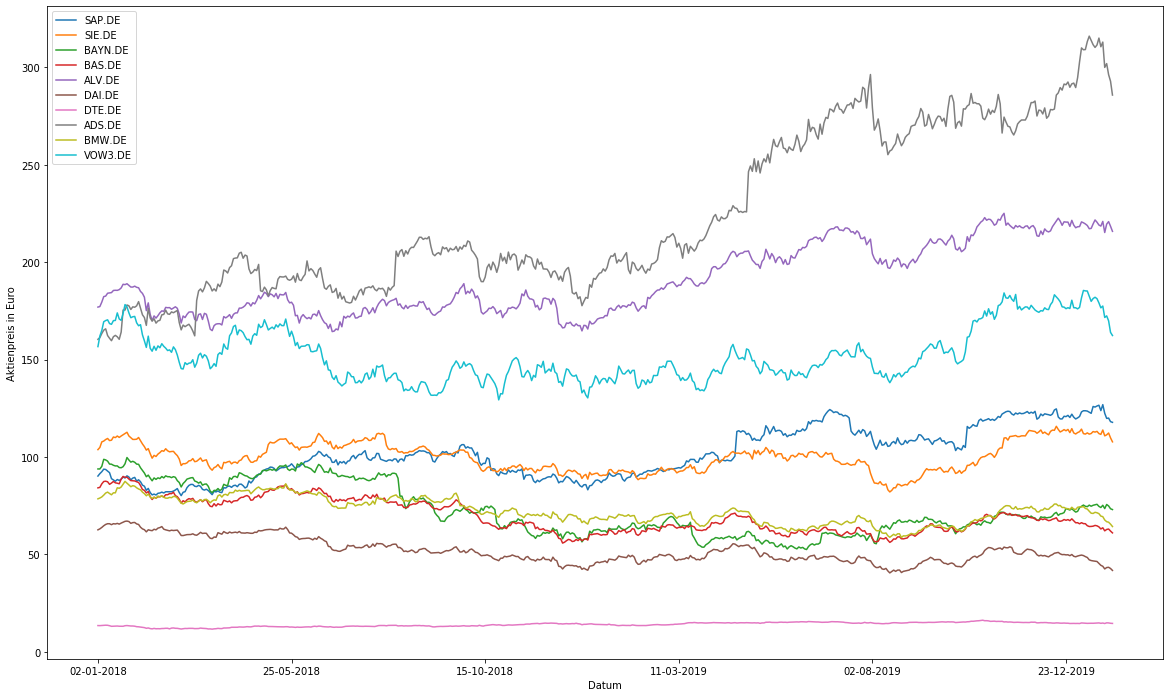

In [2]:
from environment import Environment
from utils import *
env = Environment()

data = env.load_data()
data.plot(figsize=(20,12))
plt.ylabel('Aktienpreis in Euro')

In [3]:
# Grundlegende Vereinbarungen
N_ASSETS = 10 # Anzahl der Aktien 
WINDOW_FIT = 125 # Trainingszeitraum in Tagen, entspricht ~ 6 Monaten
WINDOW_HOLD = 125 # Haltezeitraum in Tagen 
env = Environment() # Import der Klasse Environment zum der Einlesen der Daten, sowie Bestimmung der Aktien-, Portfoliorendite etc.



# Autoencoder 


<div>
<img src="Autoencoder_Netz.png" width="350"/>
</div>


- Ziel der Autoencoder: Dimensionsreduzierung der ursprünglichen Daten
- $f:X \rightarrow F $ Encoderfunktion , $ f(x_i) = w_1 x_{i} +b_1$ falls linear, hier $f(x_i) = max(0,x_i)$
- $g:F \rightarrow X $ Decoderfunktion , $ g(x_i) = w_2 x_{i} +b_2$
- $ | x_i - ( g \circ f ) (x_i) | \rightarrow min \Leftrightarrow | x_i - w_2( max(0,x_i))+b_2 | \rightarrow min $ 
- Mittels Kleinste-Quadrate- Methode:  $\quad$
$ \sum (x_i - w_2( w_1 x_{i} +b_1 )+b_2)^2  \rightarrow min $ für die Parameter $w_1, w_2, b_1, b_2 $
- "Lernen" des Netzes mit Backpropagnition Algorithmus 





In [4]:
from agent import AutoencoderAgent # Laden der verwendeten Functionen aus der Klasse AutoencoderAgent

In [5]:
agent_ae = AutoencoderAgent(N_ASSETS, allow_short=True, encoding_dim = 5) # Dimensionsreduzierung auf 5

In [6]:
actions_equal, actions_ae = [], []
result_equal, result_ae = [], []

for i in range(WINDOW_FIT, len(env.data), WINDOW_HOLD): #Start , Stop, Schritt 
    
    # Trainingszeitraum
    state = env.get_state(i, WINDOW_FIT, is_cov_matrix=False, is_raw_time_series=True) # Daten für Trainingszeitraum 
    action_equal = np.ones(N_ASSETS) / N_ASSETS  # Benchmark  der gleichgewichteten Aktien
    action_ae = agent_ae.act(state)  # Gewichte der Aktien mittels Autoencoder
    
    
    # Realisierung der Rendite der Methode 
    state_action = env.get_state(i+WINDOW_HOLD, WINDOW_HOLD, is_cov_matrix=False) #Renditen Haltezeitraums 
    r = np.dot(state_action, action_equal) # Portfoliorendite gleichgewichtetes Portfolio
    result_equal.append(r.tolist())
    actions_equal.append(action_equal) # Aufbau Liste Renditen
    
    r = np.dot(state_action, action_ae) # Portfoliorendite Autoencoder Portfolio
    result_ae.append(r.tolist())
    actions_ae.append(action_ae)

In [7]:
result_equal_vis = [item for sublist in result_equal for item in sublist]
result_ae_vis = [item for sublist in result_ae for item in sublist]

# Evaluation

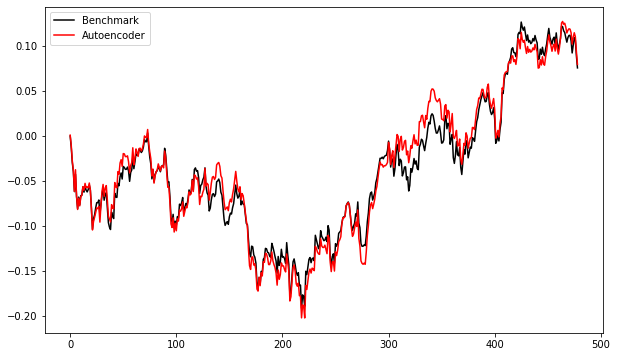

In [8]:
# Renditeverlauf des Gesamtportfolios

plt.figure(figsize=(10,6))
plt.plot(np.array(result_equal_vis).cumsum(),label='Benchmark', color = 'black')  
plt.plot(np.array(result_ae_vis).cumsum(),label='Autoencoder', color = 'red') 
plt.legend()
plt.show()

In [9]:
print('Methode' ,'Rendite','Volatilität','Sharpe-Ratio','alpha', 'beta' )
print('EQUAL', print_stats(result_equal_vis, result_equal_vis))
print('AUTOENCODER', print_stats(result_ae_vis, result_equal_vis))


Methode Rendite Volatilität Sharpe-Ratio alpha beta
EQUAL [0.0002, 0.01, 0.2502, -0.0, 1.0]
AUTOENCODER [0.0002, 0.0104, 0.2491, 0.0, 1.0096]


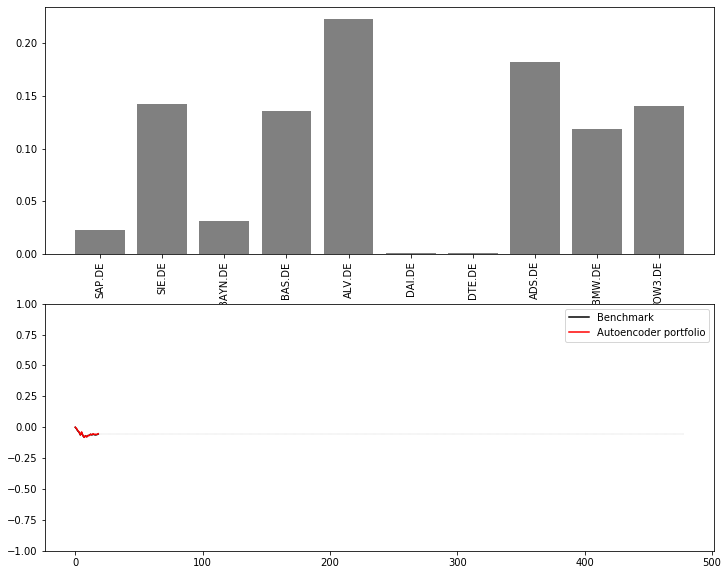

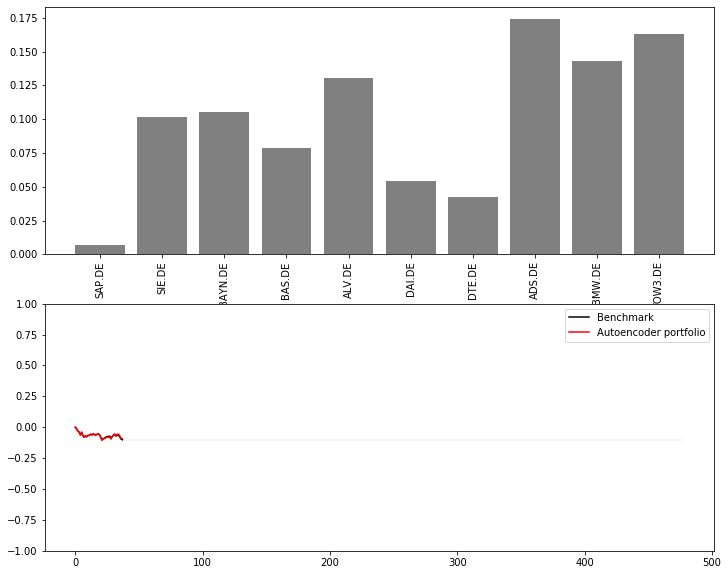

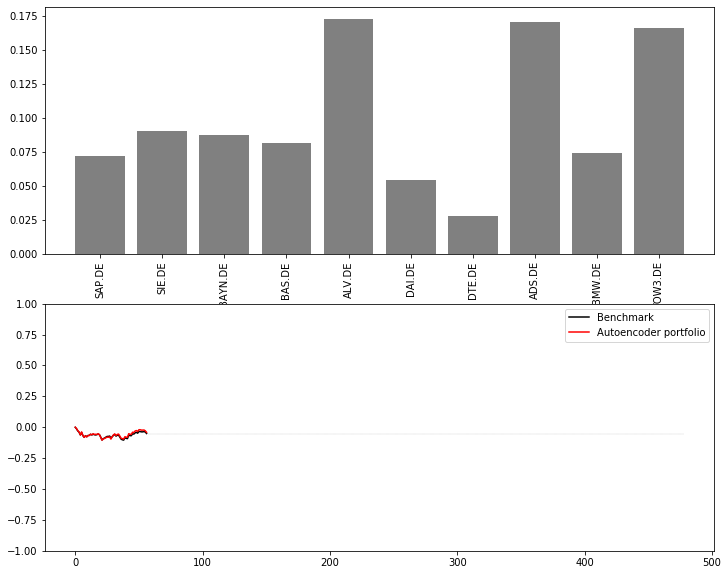

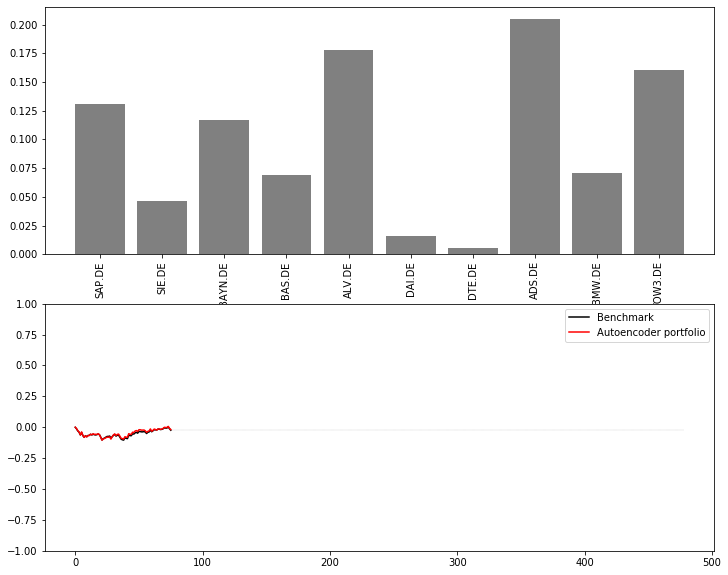

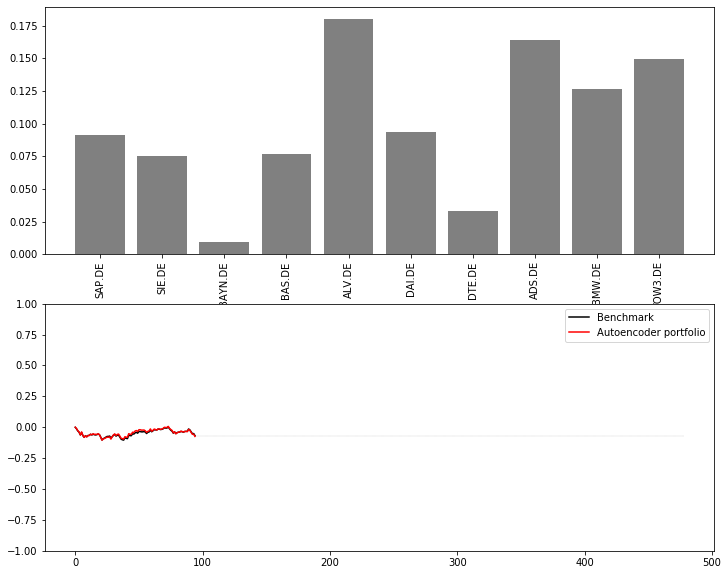

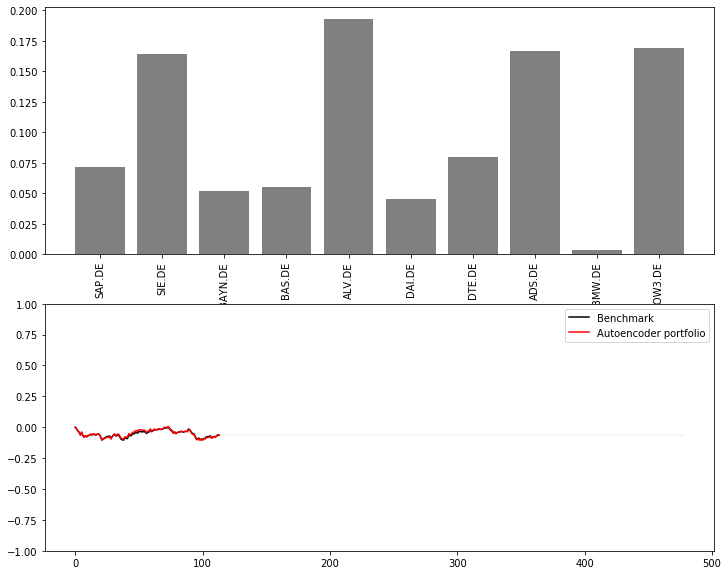

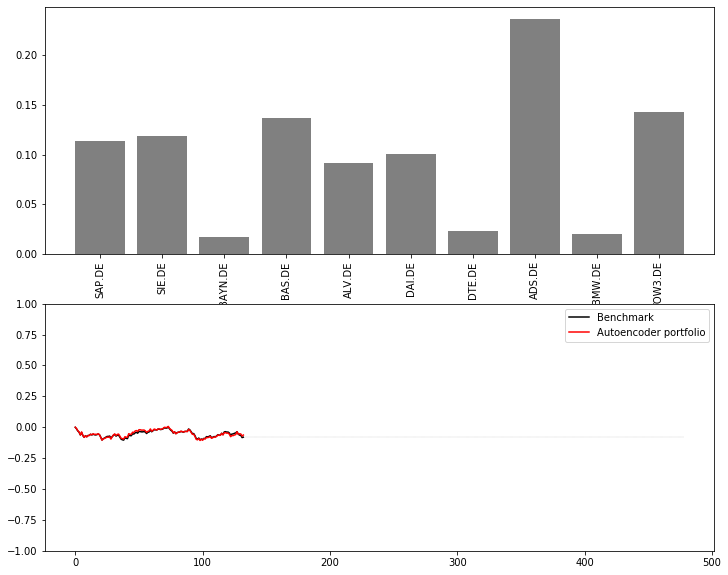

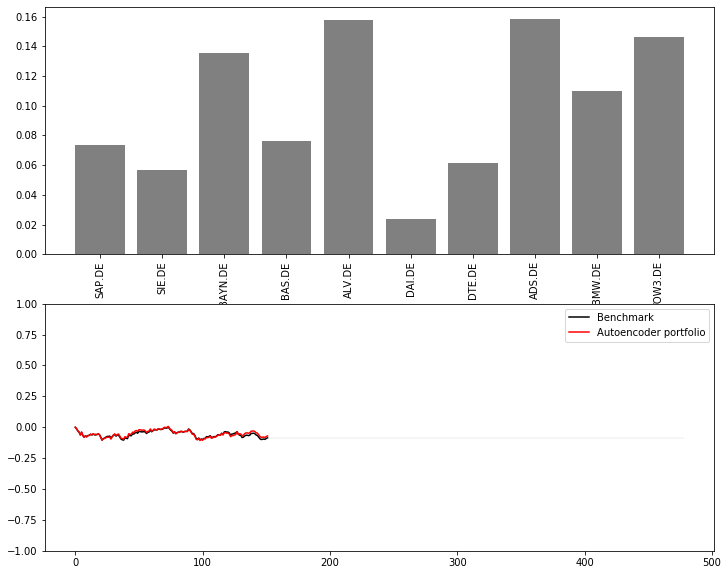

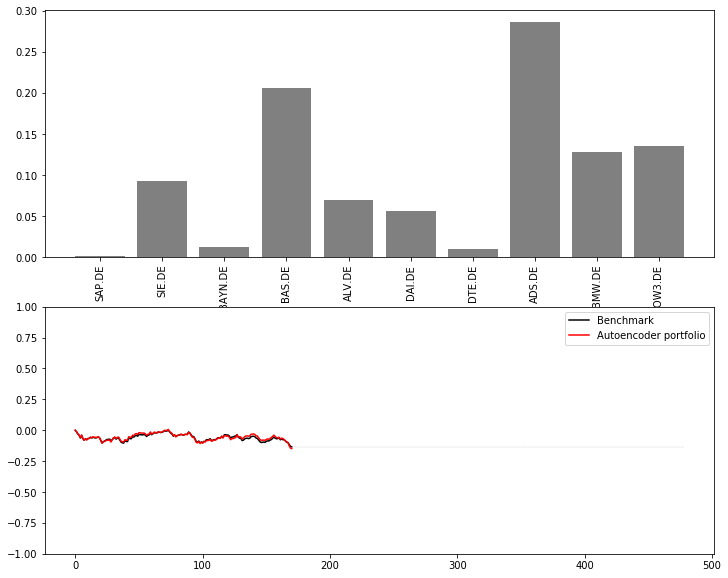

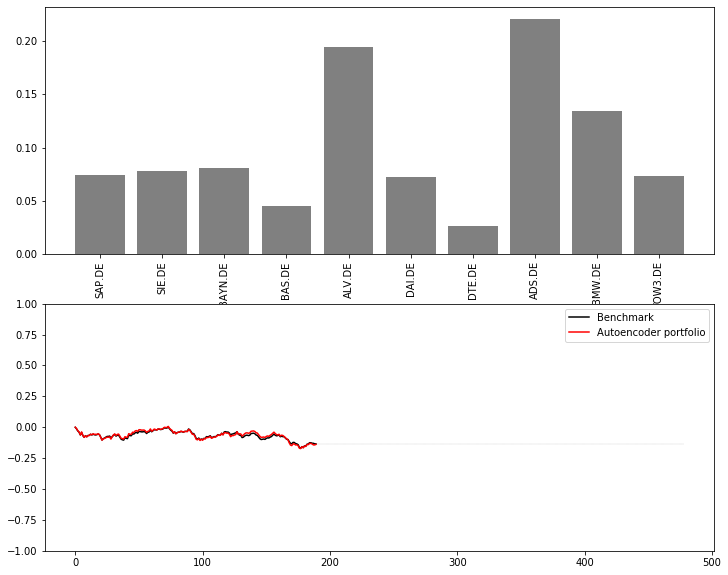

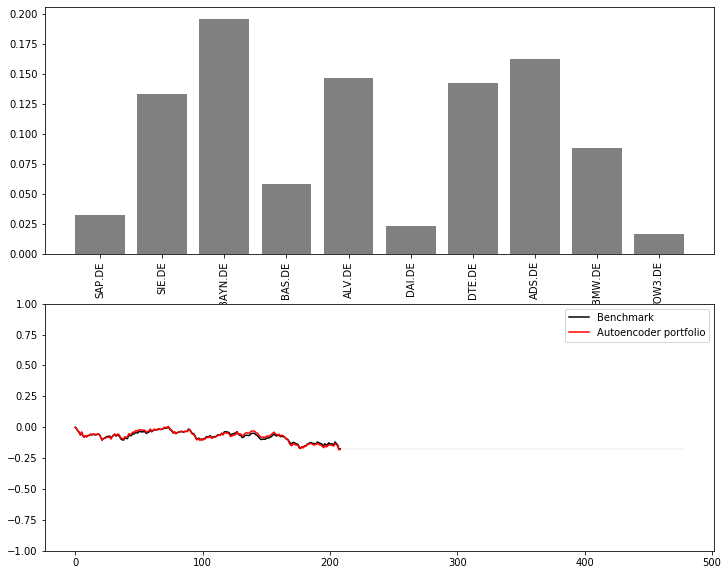

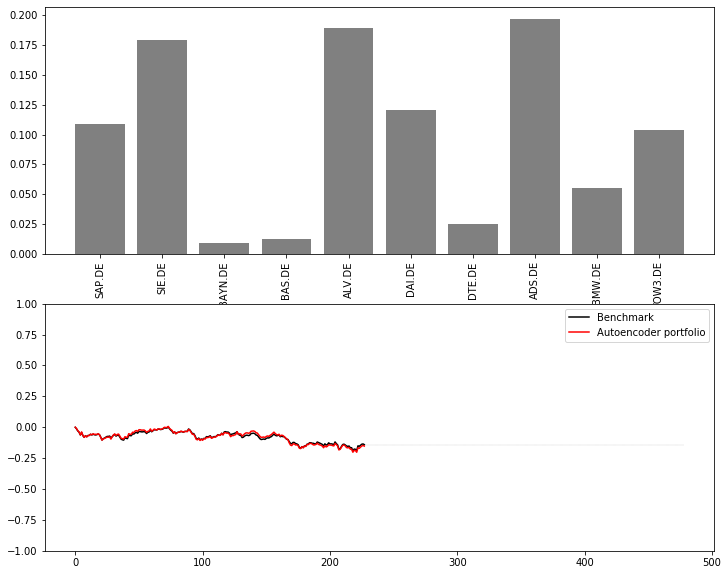

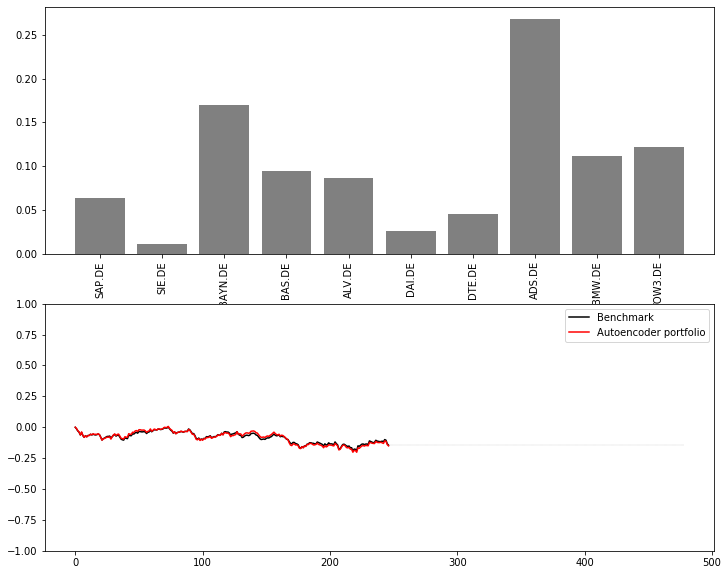

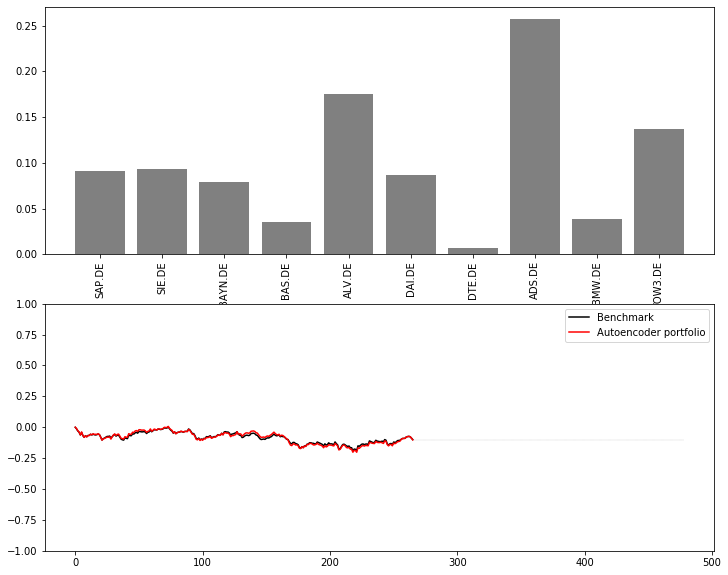

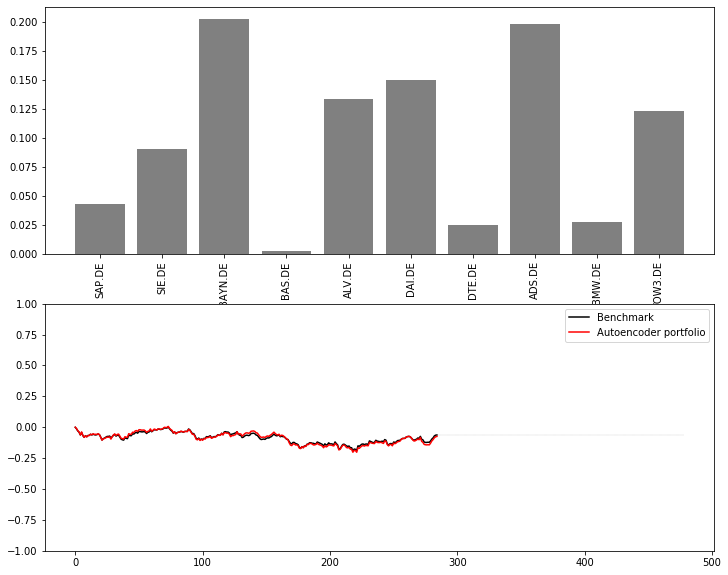

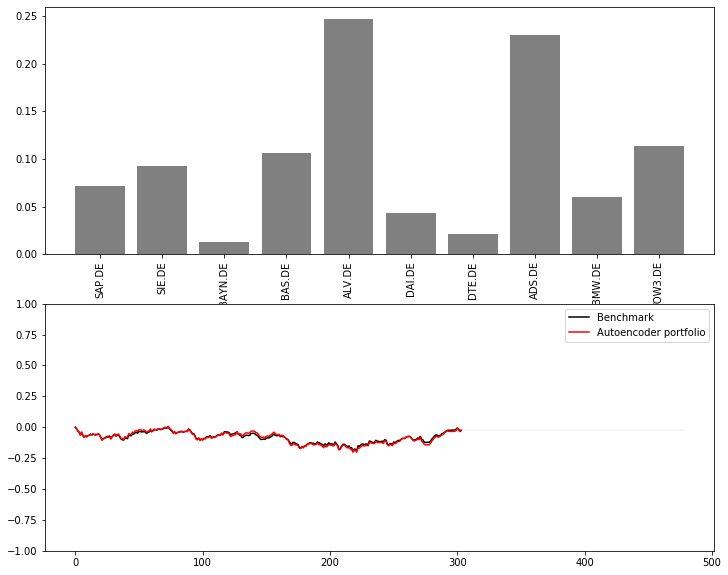

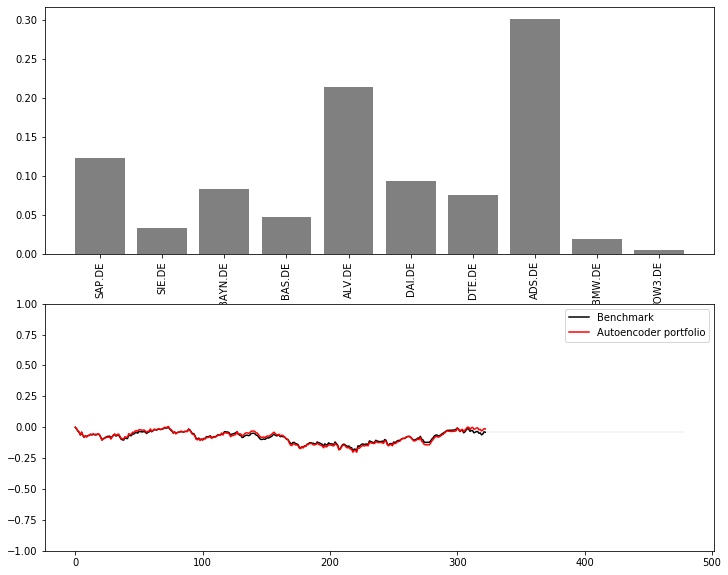

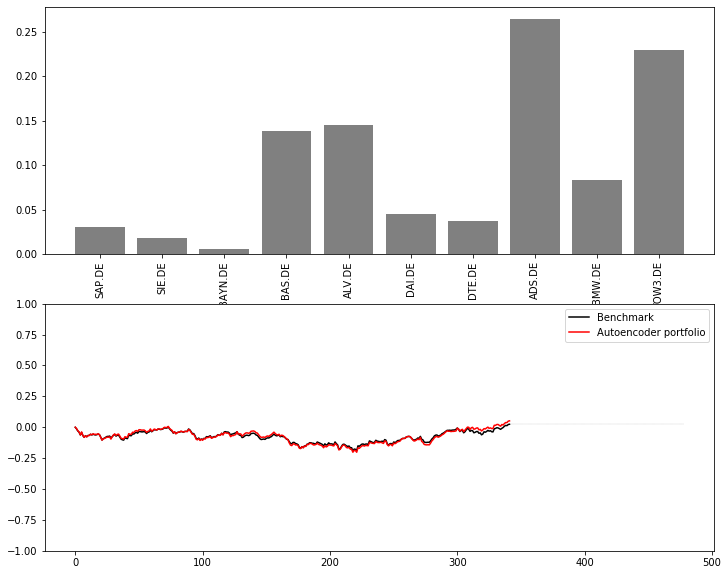

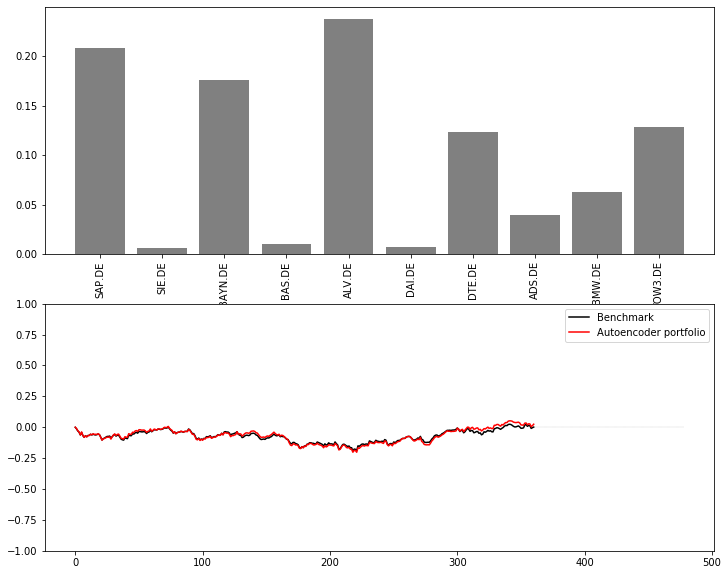

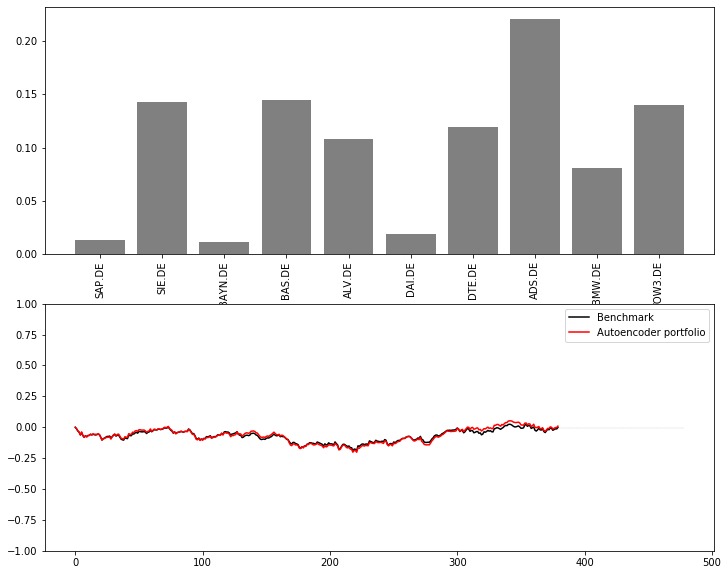

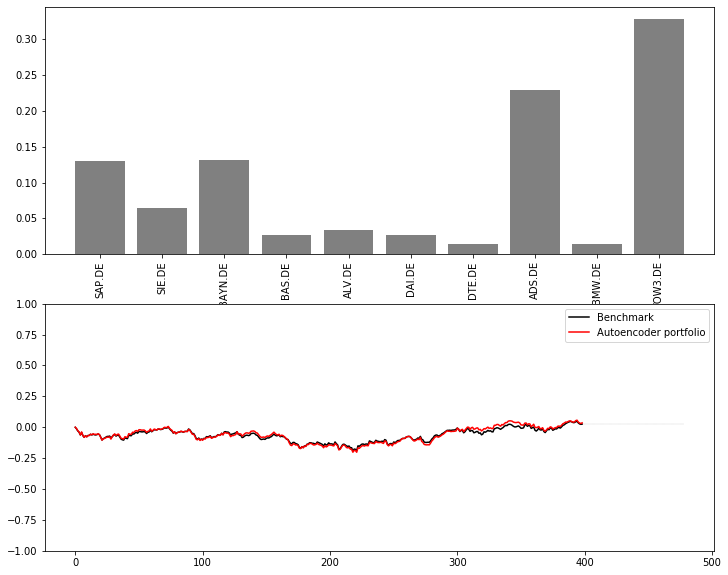

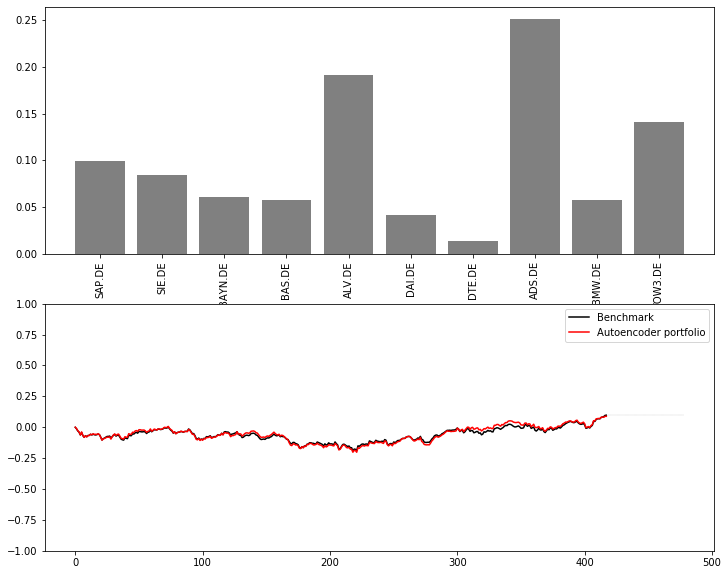

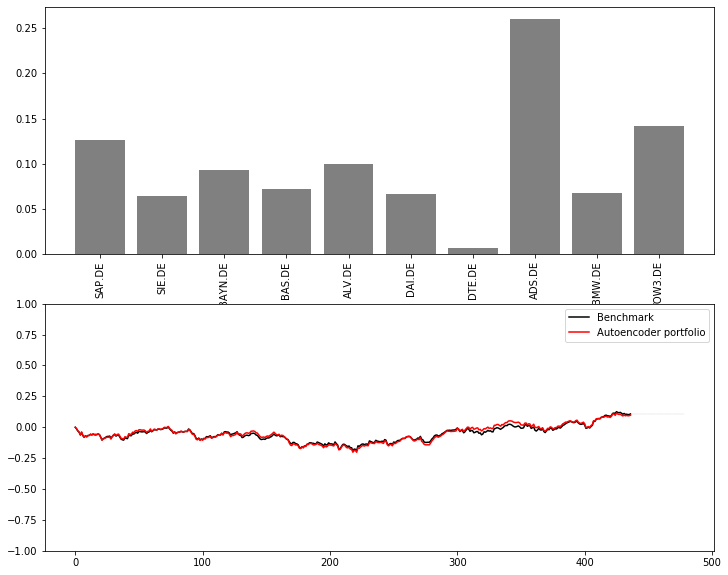

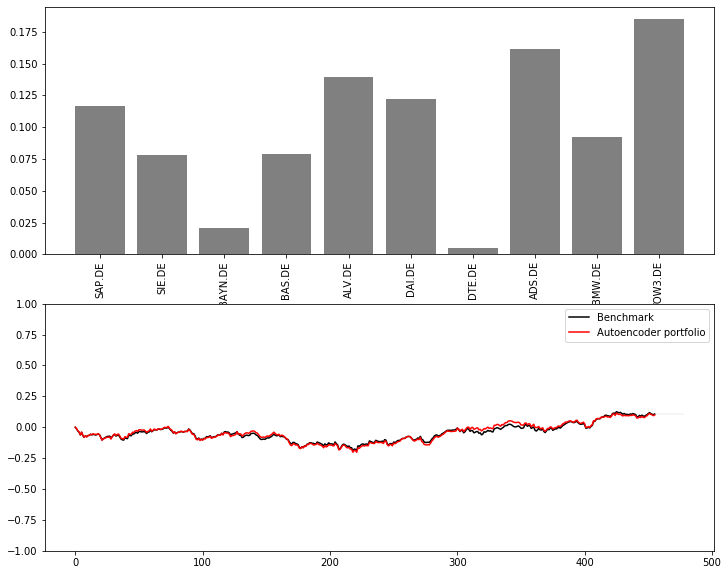

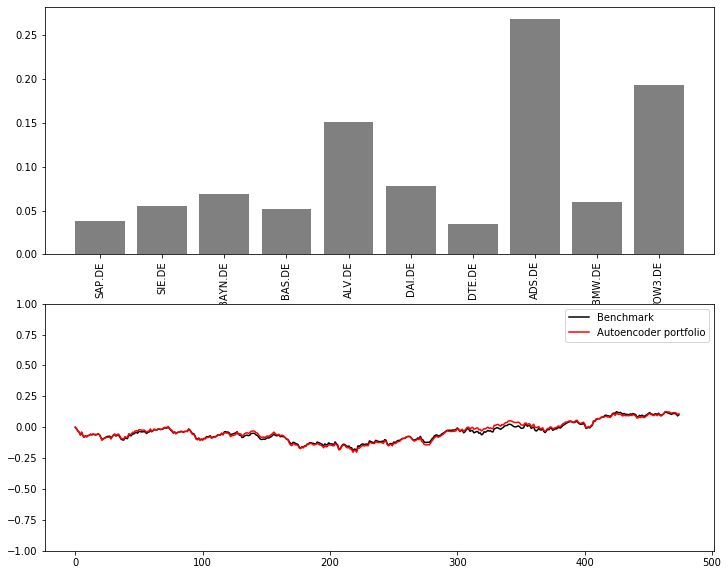

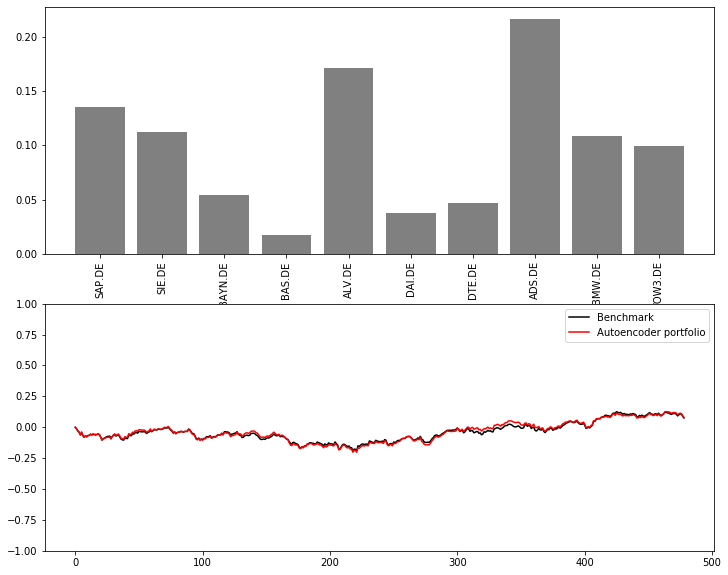

In [10]:
plot_results(result_equal, 
             result_ae, 
             actions_ae, 
             N_ASSETS,
             state.columns, 
             'Autoencoder portfolio', './images/ae/', 'series')


# Riskoaufteilung mit hierarchischem Clustering


- Methode basiert auf der Allokation von Risiko
- Kovarianzmatrix kann als vollständiger Graph gesehen werden
- Zunächst keine hierarchische Struktur in der Kovarianzmatrix vorhanden
- Clusterbildung anhand der Kovarianzmatrix
- Risiko kann anhand des Clusters rekursiv umverteilt werden


<div>
<img src="HRP_Abbildung.png" width="500"/>
</div>



### Schritte des Algorithmus zur Erzeugung der hierarchischen Struktur:
1. Cluster erstellen  
1. Quasi Diagonalisierung
1. Rekursive Bisektion

wobei in den Schritten 1-3 jeweils einzelne Algorithmen angewendet werden

In [11]:
from agent import HRPAgent
agent_hrp = HRPAgent(N_ASSETS, allow_short=True)

In [12]:
actions_equal, actions_hrp = [], []
result_equal, result_hrp = [], []

for i in range(WINDOW_FIT, len(env.data), WINDOW_HOLD):
    # Trainingszeitraum
    state = env.get_state(i, WINDOW_FIT, is_cov_matrix=False)# Daten für Trainingszeitraum 
    action_equal = np.ones(N_ASSETS) / N_ASSETS # Benchmark  der gleichgewichteten Aktien
    action_hrp = agent_hrp.act(state) # Gewi3chte der Aktien mittels Autoencoder

    # Realisierung der Rendite der Methode 
    state_action = env.get_state(i+WINDOW_HOLD, WINDOW_HOLD, is_cov_matrix=False) # Renditen Haltezeitraums 
    
    r = np.dot(state_action, action_equal) # Portfoliorendite gleichgewichtetes Portfolio
    result_equal.append(r.tolist())
    actions_equal.append(action_equal)
    
    r = np.dot(state_action, action_hrp) # Portfoliorendite hierarchisches Clustering 
    result_hrp.append(r.tolist())
    actions_hrp.append(action_hrp)

In [13]:
result_equal_vis = [item for sublist in result_equal for item in sublist]
result_hrp_vis = [item for sublist in result_hrp for item in sublist]

# Evaluation

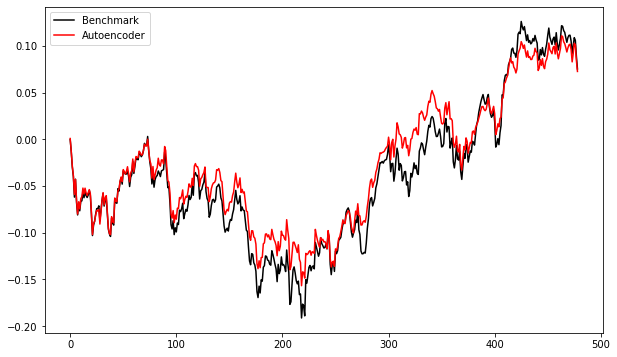

In [14]:
# Renditeverlauf des Gesamtportfolios

plt.figure(figsize=(10,6))
plt.plot(np.array(result_equal_vis).cumsum(),label='Benchmark', color = 'black')  
plt.plot(np.array(result_hrp_vis).cumsum(),label='Autoencoder', color = 'red') 
plt.legend()
plt.show()

In [15]:
print('Portfolio' ,'Rendite','Volatilität','Sharpe-Ratio','alpha', 'beta' )
print('EQUAL HRP', print_stats(result_equal_vis, result_equal_vis))
print('HRP', print_stats(result_hrp_vis, result_equal_vis))

Portfolio Rendite Volatilität Sharpe-Ratio alpha beta
EQUAL HRP [0.0002, 0.01, 0.2502, -0.0, 1.0]
HRP [0.0002, 0.0089, 0.2687, 0.0, 0.8495]


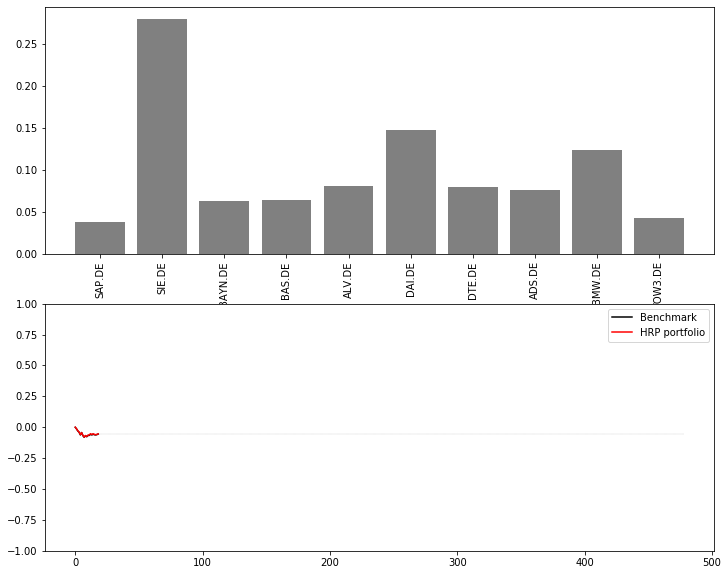

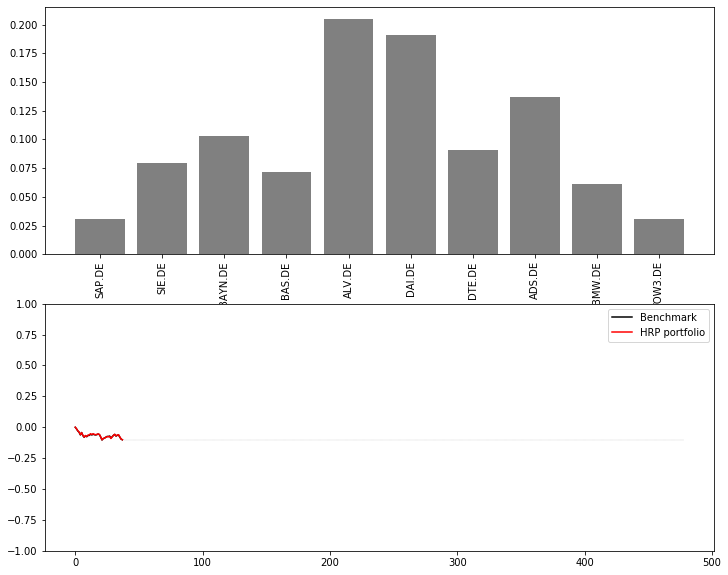

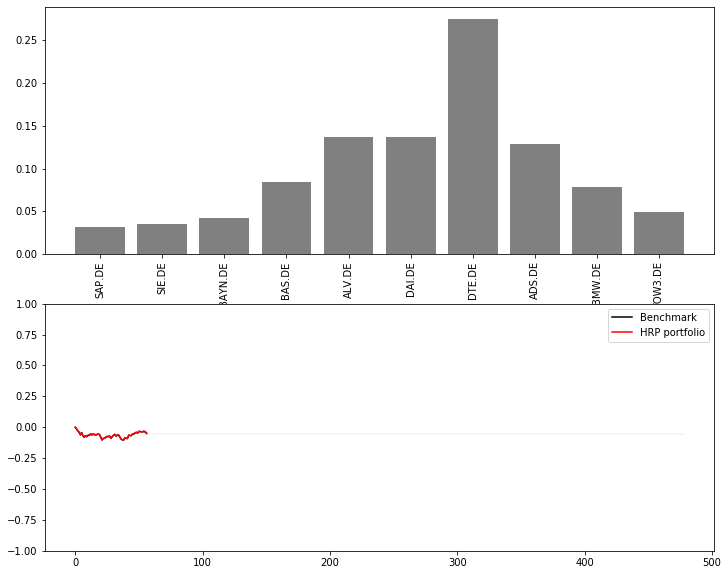

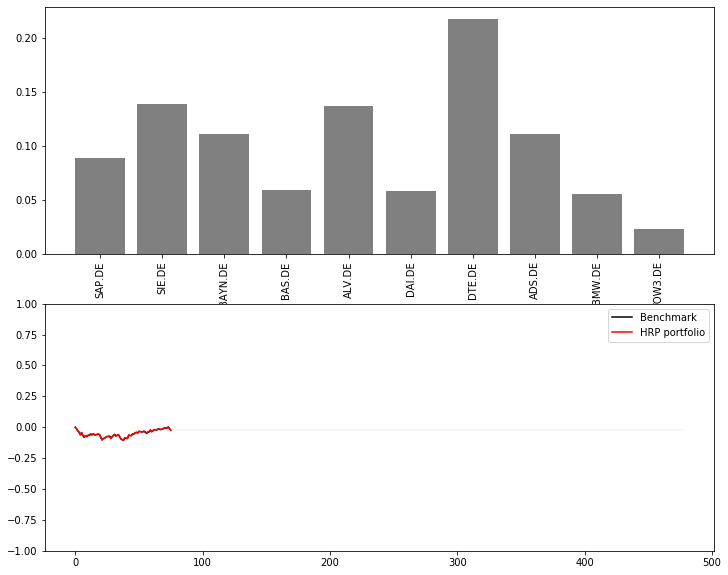

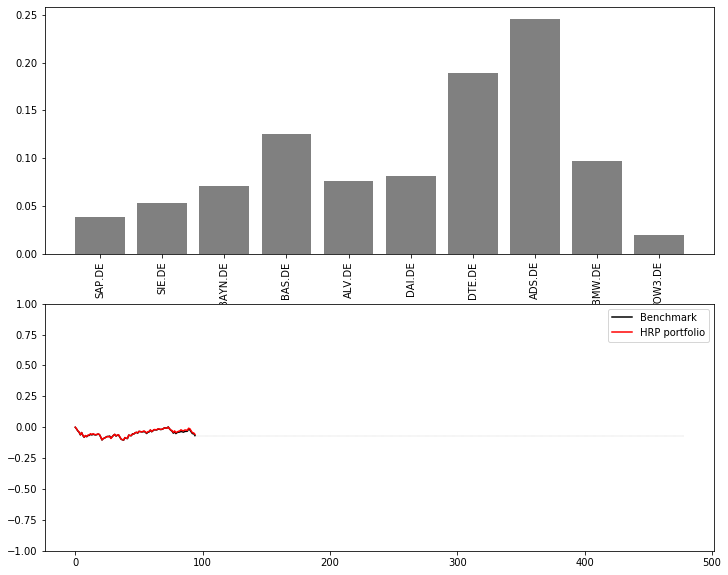

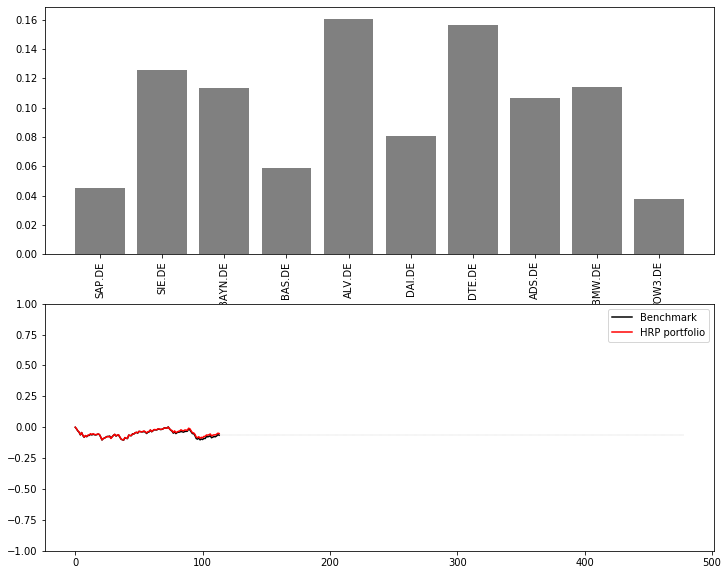

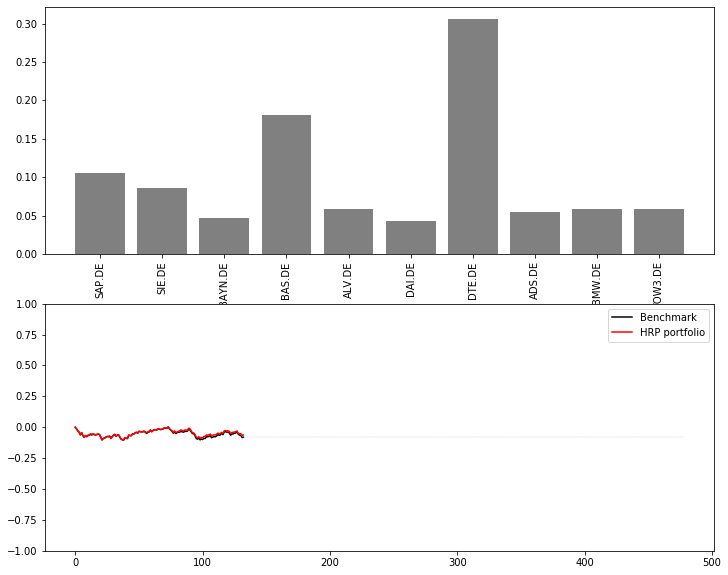

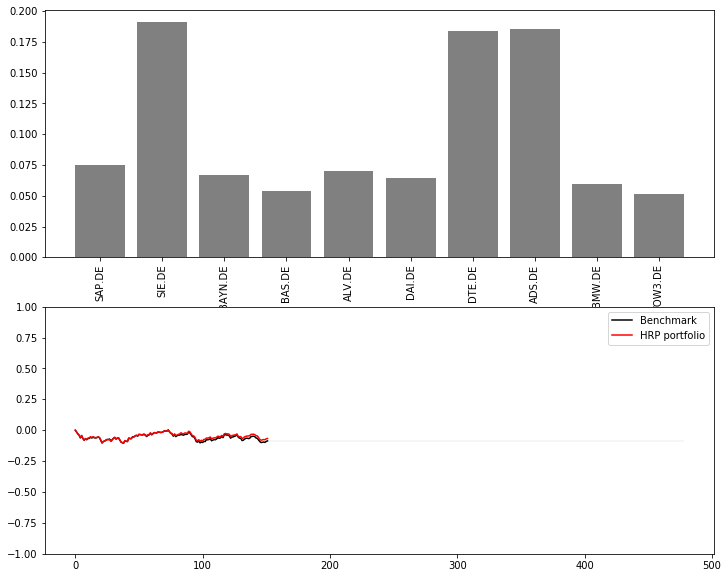

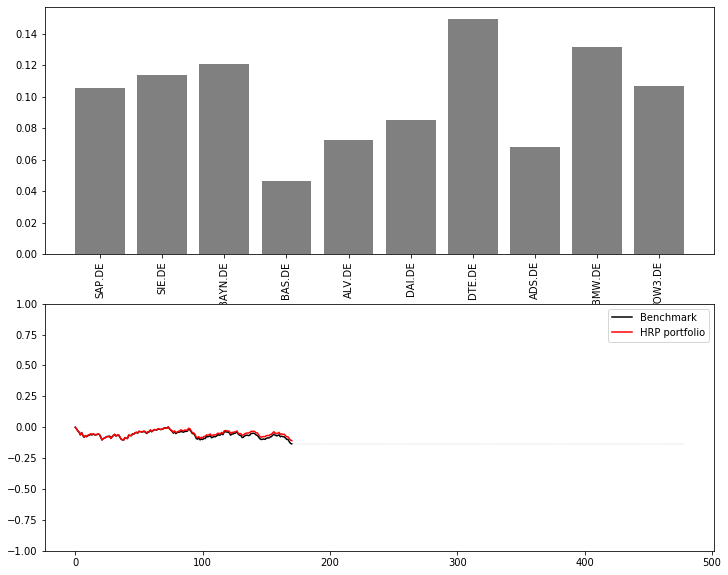

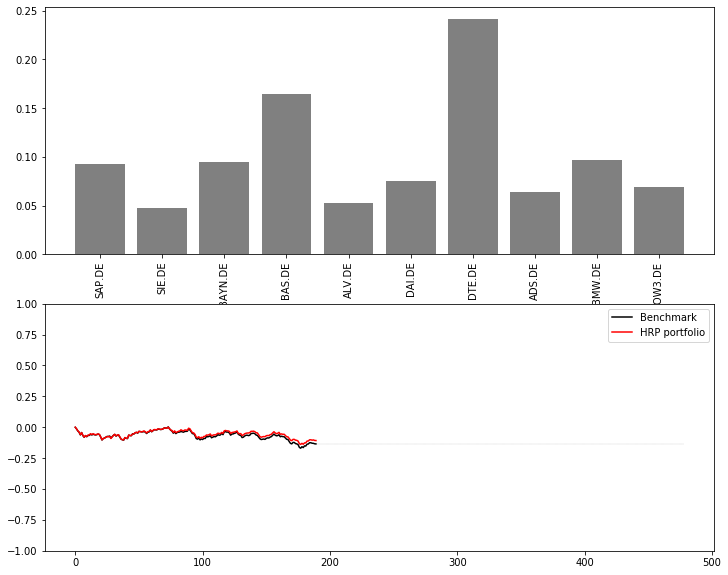

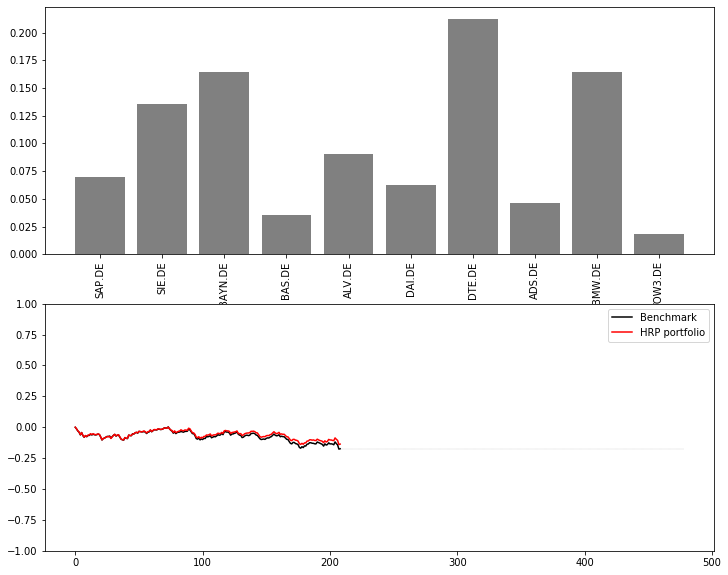

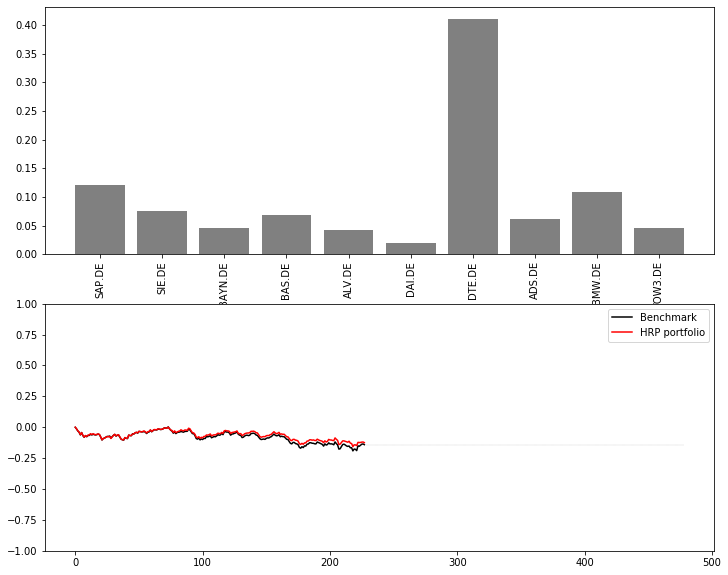

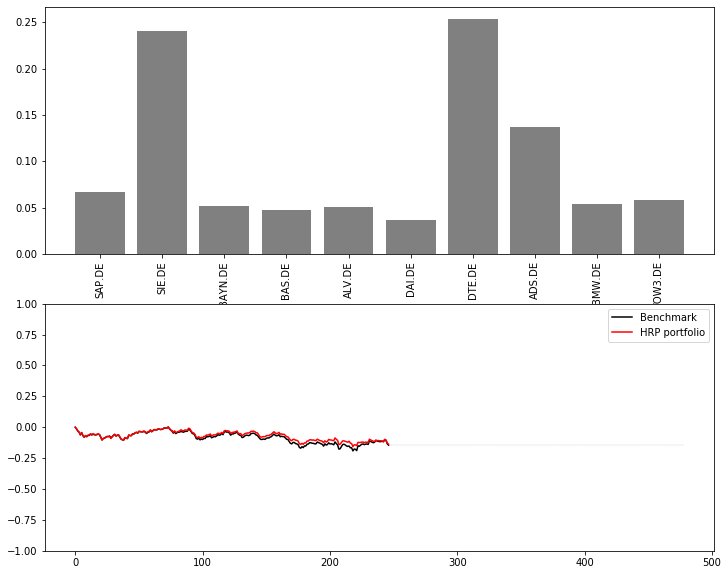

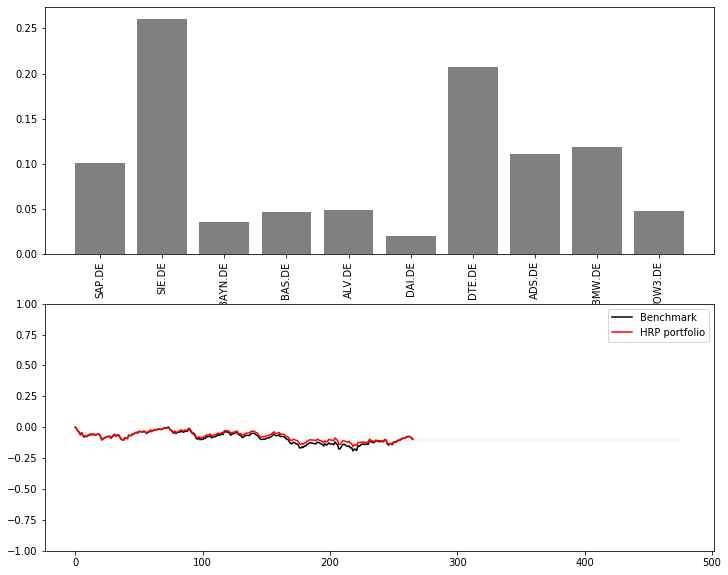

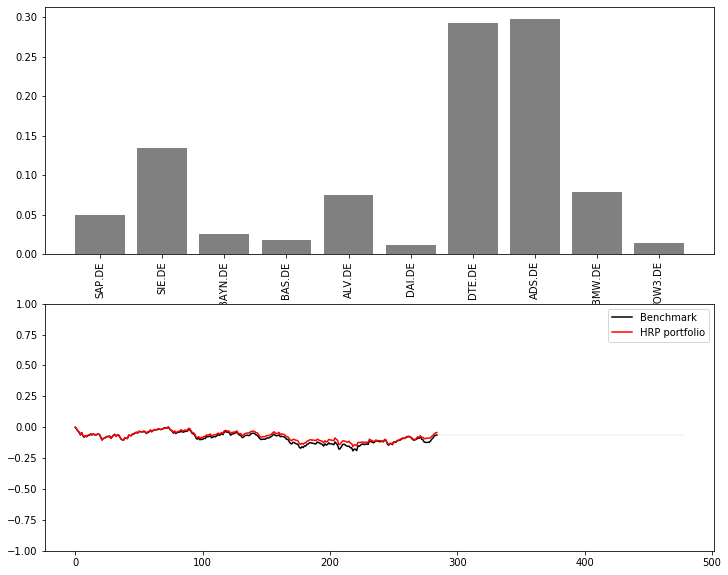

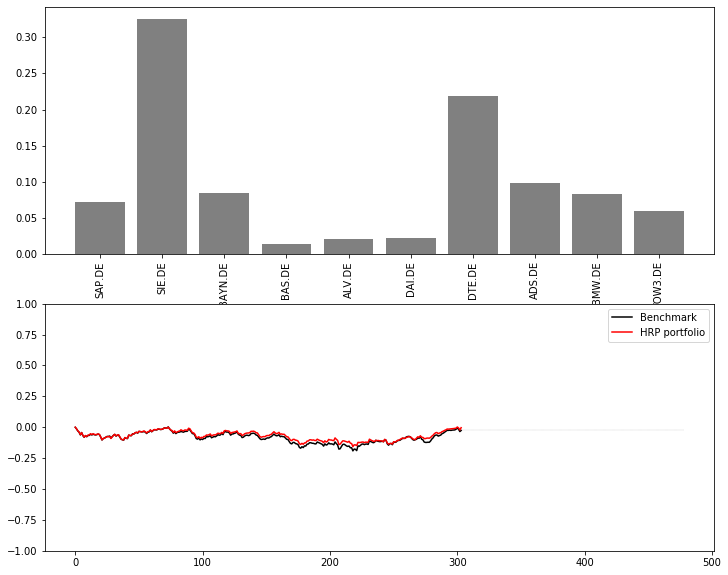

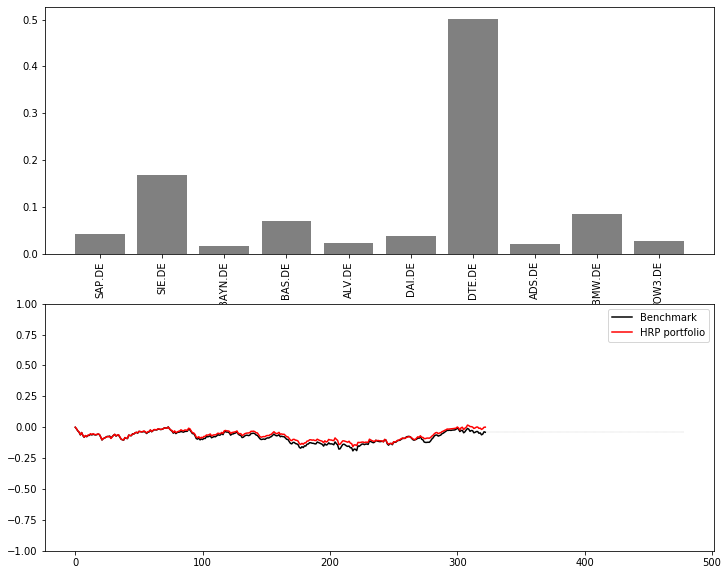

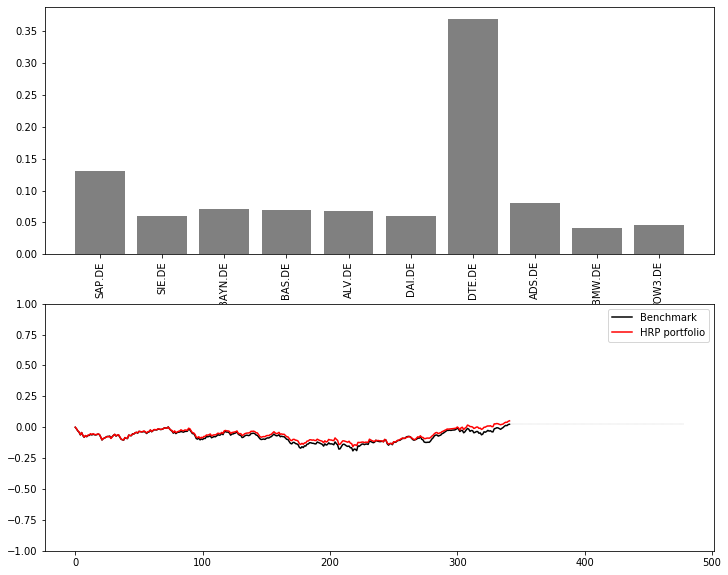

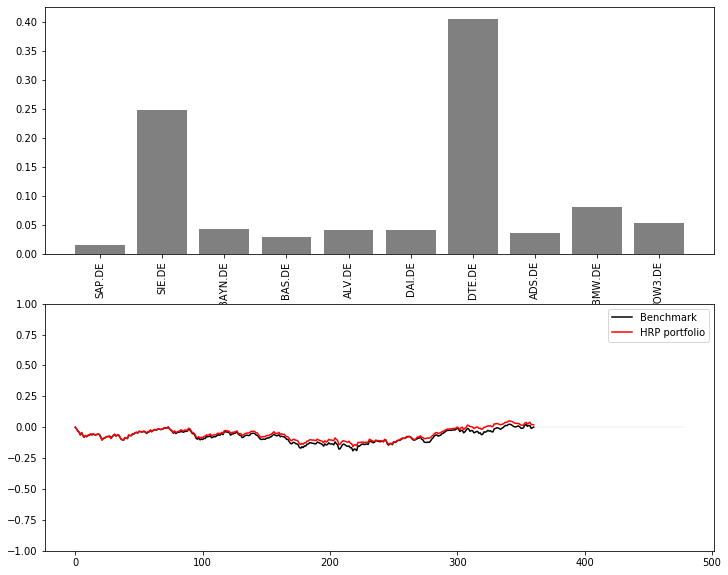

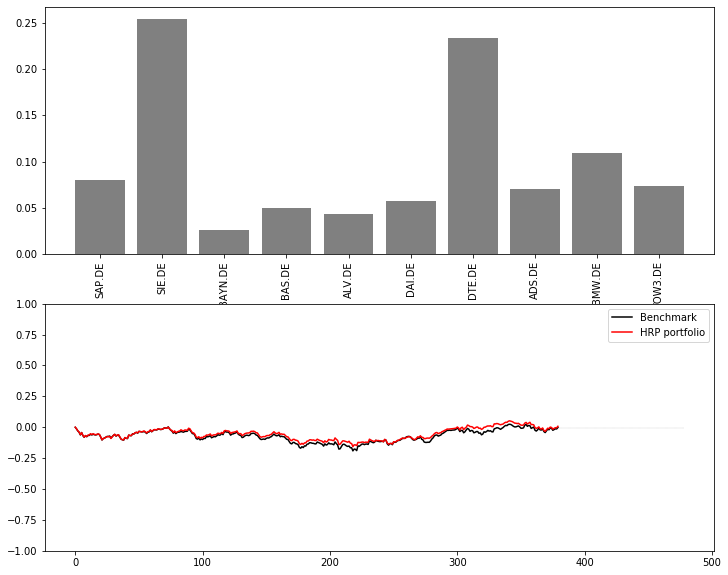

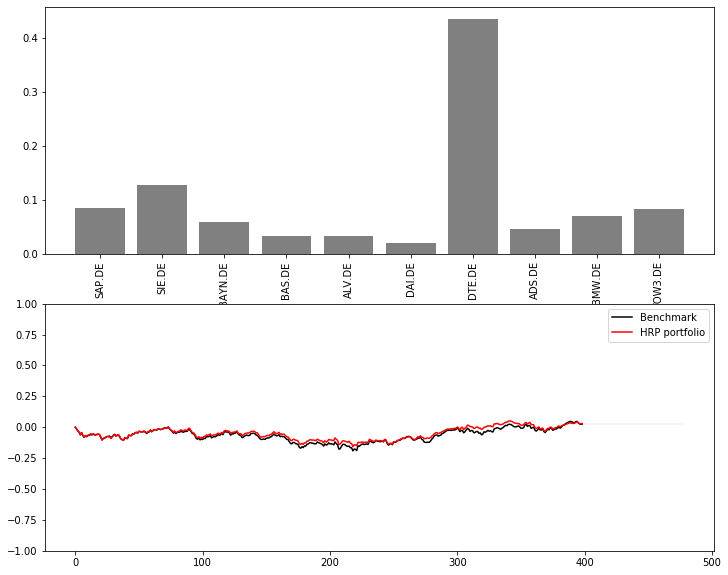

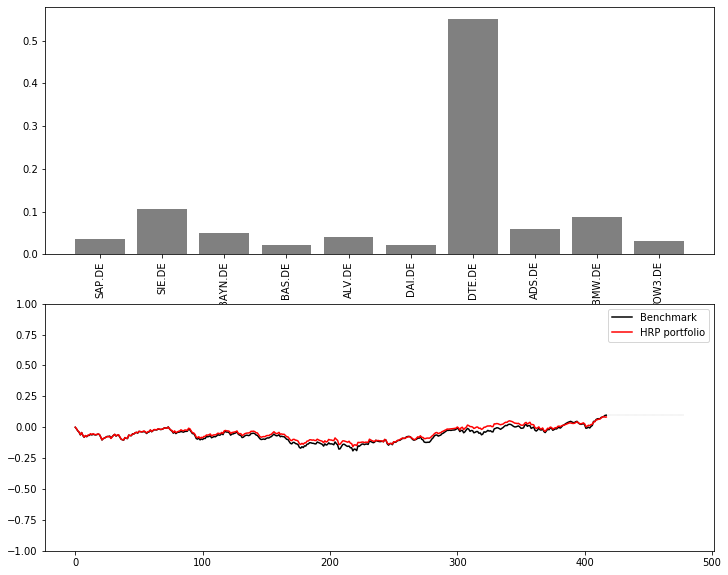

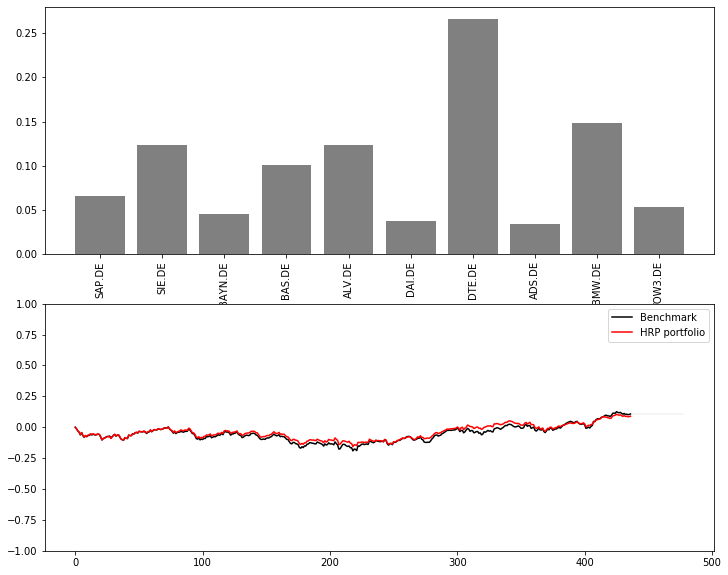

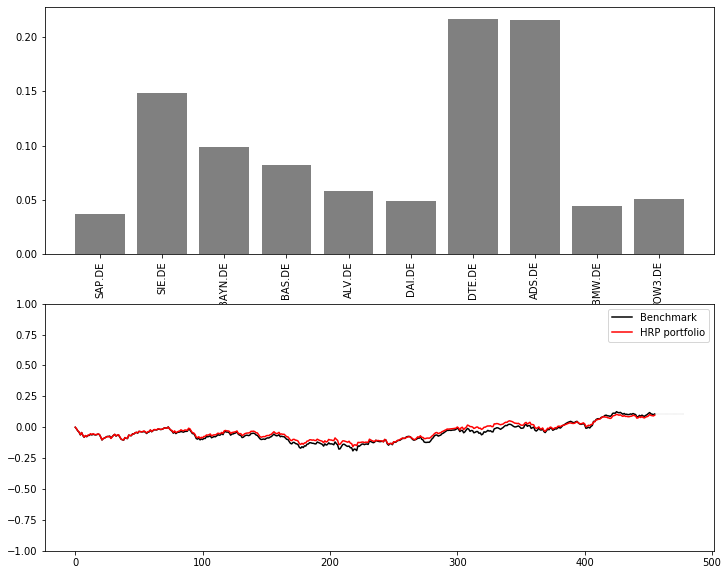

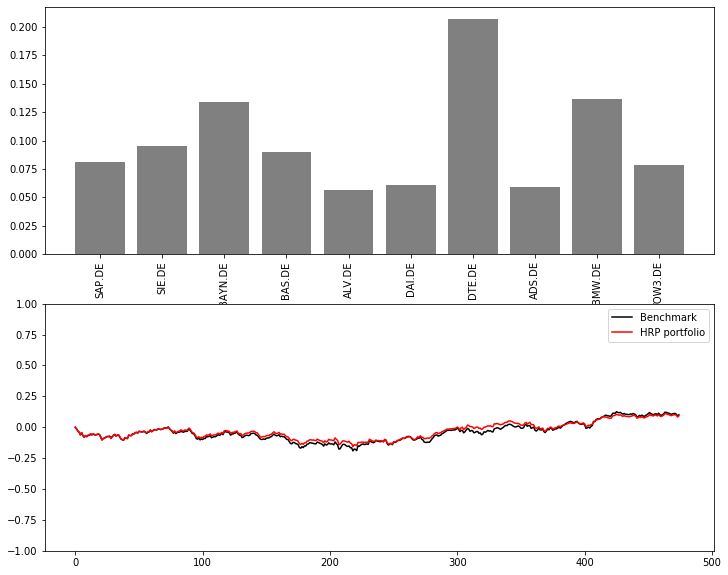

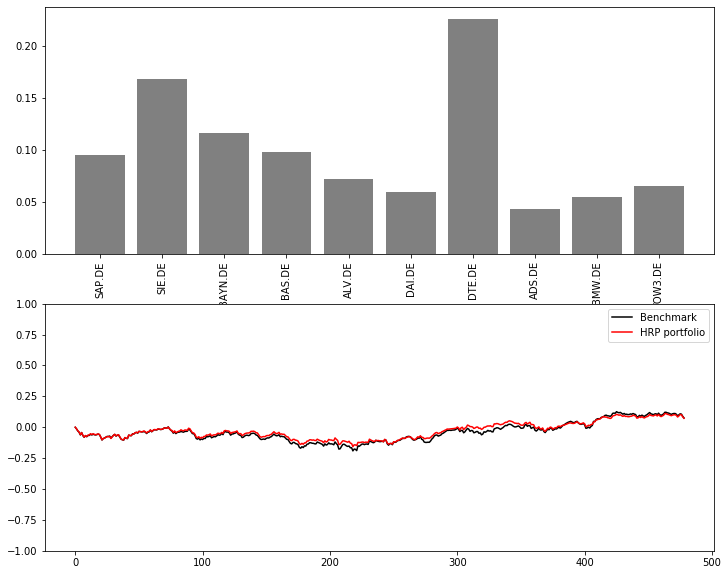

In [16]:
plot_results(result_equal, 
             result_hrp, 
             actions_hrp, 
             N_ASSETS,
             state.columns, 
             'HRP portfolio', './images/hrp/', 'series')

# Prognosebasiertes Portfolio 



##### Idee:
Wenn ein Modell zur Prognose der zukünftigen Aktienpreise exisitiert, können anhand der prognostizierten Preise entsprechende Gewichte verteilt werden, um die Rendite zu erhöhen oder das Risiko zu minimieren.

### Exponentielles Glätten
- $\hat{R_{t}} = \alpha \cdot R_{{t}}+(1-\alpha )\cdot \hat{R_{{t-1}}}  $ wobei $\alpha \in [0,1] $  - Glättungsfaktor und $\hat{R_{t}}$ die geschätzte Rendite 
- Glättungsfaktor $\alpha $ , wobei 
   - für $ \alpha =1 $ entspricht der Vorhersagewert dem Messwert  ( keine Glättung ) 
   - für $ \alpha =0 $ horizontale Glättung der Zeitreihe ( neuer Vorhersagewert entspricht dem alten Wert) 



In [17]:
from agent import SmoothingAgent

In [18]:
agent_smooth = SmoothingAgent(N_ASSETS, allow_short=True, forecast_horizon = WINDOW_HOLD) # Prognosezeitraum = Haltedauer

In [19]:
actions_equal, actions_smooth = [], []
result_equal, result_smooth = [], []

for i in range(WINDOW_FIT, len(env.data), WINDOW_HOLD):
    # Trainingszeitraum
    state = env.get_state(i, WINDOW_FIT, is_cov_matrix=False, is_raw_time_series=True)# Daten für Trainingszeitraum 
    action_equal = np.ones(N_ASSETS) / N_ASSETS # Benchmark  der gleichgewichteten Aktien
    action_smooth = agent_smooth.act(state) # Gewichte der Aktien mittels exp. Glätten

    # Realisierung der Rendite der Methode 
    state_action = env.get_state(i+WINDOW_HOLD, WINDOW_HOLD, is_cov_matrix=False)
    
    r = np.dot(state_action, action_equal) # Portfoliorendite gleichgewichtetes Portfolio
    result_equal.append(r.tolist())
    actions_equal.append(action_equal)
    
    r = np.dot(state_action, action_smooth) # Portfoliorendite - Prognose exponentielle Glättung
    result_smooth.append(r.tolist())
    actions_smooth.append(action_smooth)

/opt/anaconda3/envs/keras/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/anaconda3/envs/keras/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:222: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)
/opt/anaconda3/envs/keras/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/opt/anaconda3/envs/keras/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignore

/opt/anaconda3/envs/keras/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/anaconda3/envs/keras/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:222: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)
/opt/anaconda3/envs/keras/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/opt/anaconda3/envs/keras/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignore

/opt/anaconda3/envs/keras/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/opt/anaconda3/envs/keras/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/anaconda3/envs/keras/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:222: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)
/opt/anaconda3/envs/keras/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/opt/anac

/opt/anaconda3/envs/keras/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:222: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)
/opt/anaconda3/envs/keras/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/opt/anaconda3/envs/keras/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/anaconda3/envs/keras/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:222: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)


/opt/anaconda3/envs/keras/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:222: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)
/opt/anaconda3/envs/keras/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/opt/anaconda3/envs/keras/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/anaconda3/envs/keras/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:222: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)


/opt/anaconda3/envs/keras/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:222: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)
/opt/anaconda3/envs/keras/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/opt/anaconda3/envs/keras/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/anaconda3/envs/keras/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:222: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)


/opt/anaconda3/envs/keras/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/anaconda3/envs/keras/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/opt/anaconda3/envs/keras/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/anaconda3/envs/keras/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:222: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)
/opt/anaconda3/envs/keras/lib/python3.7/site-packages/stat

/opt/anaconda3/envs/keras/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:222: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)
/opt/anaconda3/envs/keras/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/opt/anaconda3/envs/keras/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/anaconda3/envs/keras/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:222: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)


/opt/anaconda3/envs/keras/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:222: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)
/opt/anaconda3/envs/keras/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/opt/anaconda3/envs/keras/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/anaconda3/envs/keras/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:222: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)


/opt/anaconda3/envs/keras/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:222: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)
/opt/anaconda3/envs/keras/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/opt/anaconda3/envs/keras/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/anaconda3/envs/keras/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:222: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)


/opt/anaconda3/envs/keras/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/opt/anaconda3/envs/keras/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/anaconda3/envs/keras/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:222: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)
/opt/anaconda3/envs/keras/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/opt/anac

/opt/anaconda3/envs/keras/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:222: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)
/opt/anaconda3/envs/keras/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/opt/anaconda3/envs/keras/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/anaconda3/envs/keras/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:222: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)


/opt/anaconda3/envs/keras/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/opt/anaconda3/envs/keras/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/anaconda3/envs/keras/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:222: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)
/opt/anaconda3/envs/keras/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/opt/anac

/opt/anaconda3/envs/keras/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [20]:
result_equal_vis = [item for sublist in result_equal for item in sublist]
result_smooth_vis = [item for sublist in result_smooth for item in sublist]



# Evaluation

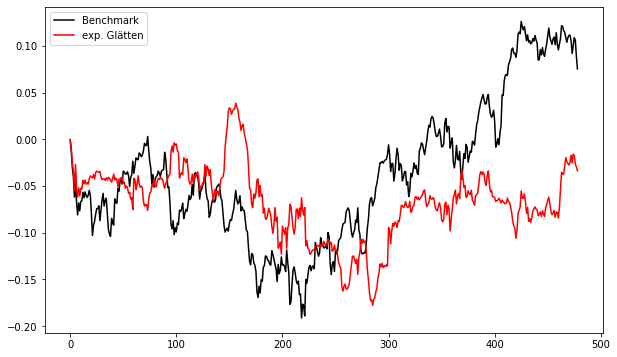

In [21]:
# Renditeverlauf des Gesamtportfolios

plt.figure(figsize=(10,6))
plt.plot(np.array(result_equal_vis).cumsum(),label='Benchmark', color = 'black')  
plt.plot(np.array(result_smooth_vis).cumsum(),label='exp. Glätten', color = 'red') 
plt.legend()
plt.show()



In [22]:
print('Portfolio' ,'Rendite','Volatilität','Sharpe-Ratio','alpha', 'beta' )
print('EQUAL', print_stats(result_equal_vis, result_equal_vis))
print('SMOOTHING', print_stats(result_smooth_vis, result_equal_vis))

Portfolio Rendite Volatilität Sharpe-Ratio alpha beta
EQUAL [0.0002, 0.01, 0.2502, -0.0, 1.0]
SMOOTHING [-0.0001, 0.0088, -0.1249, -0.0, -0.1337]


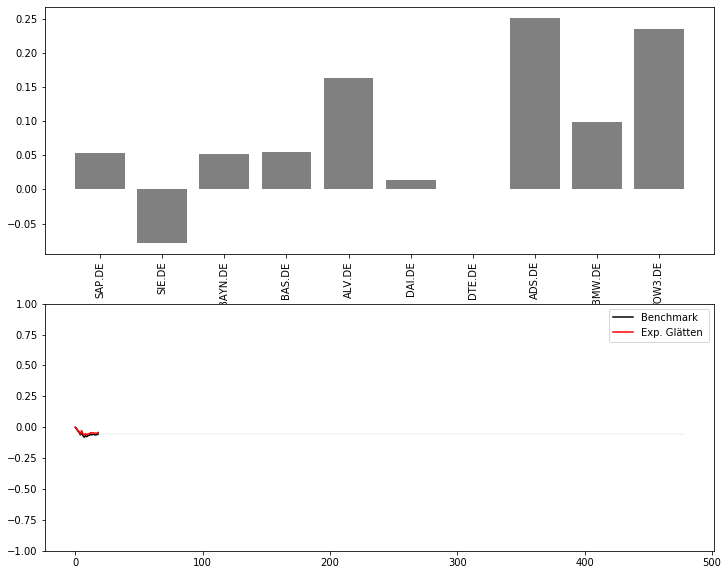

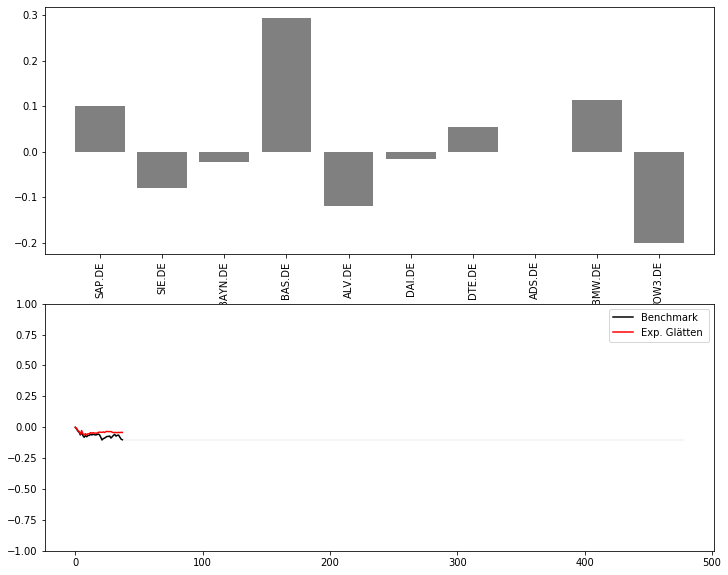

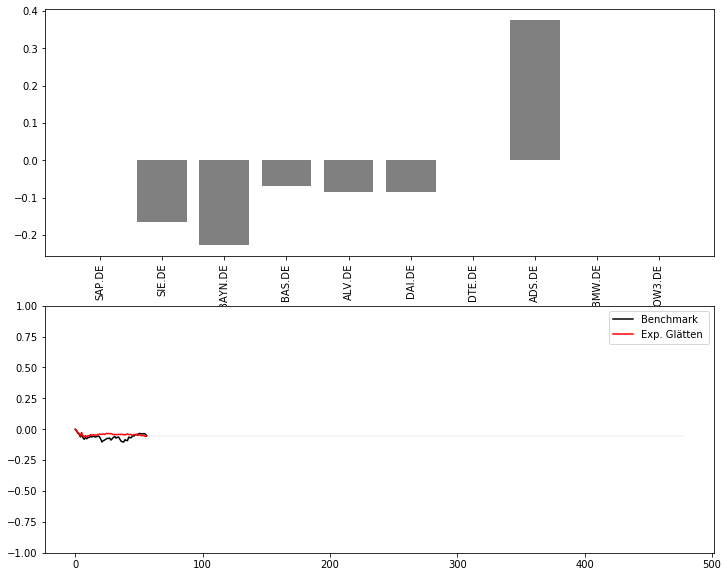

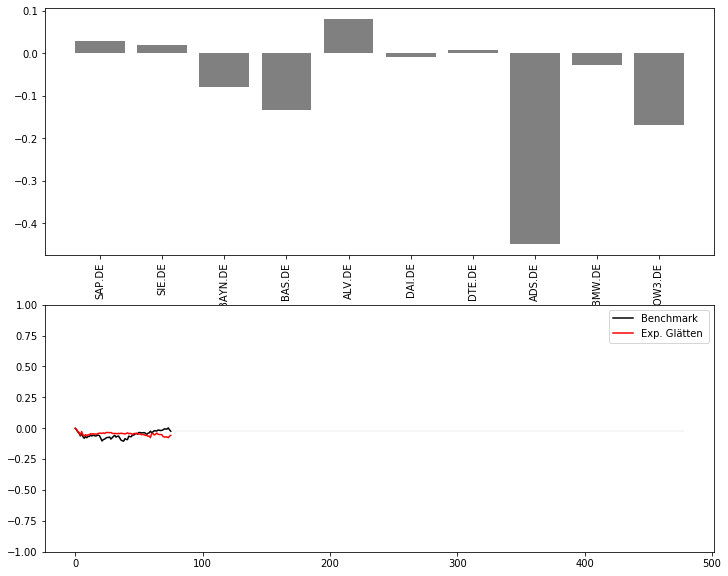

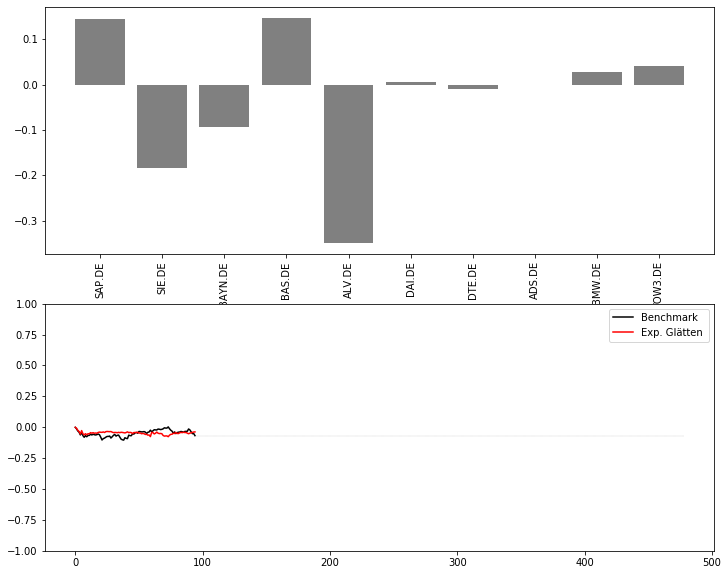

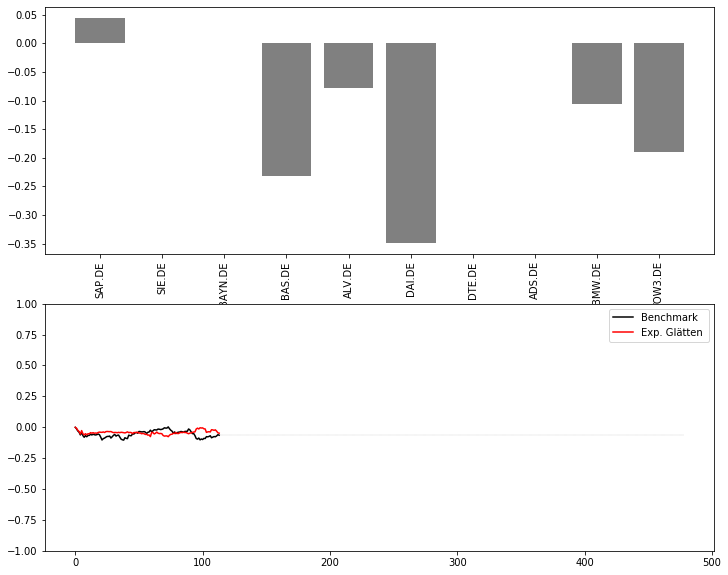

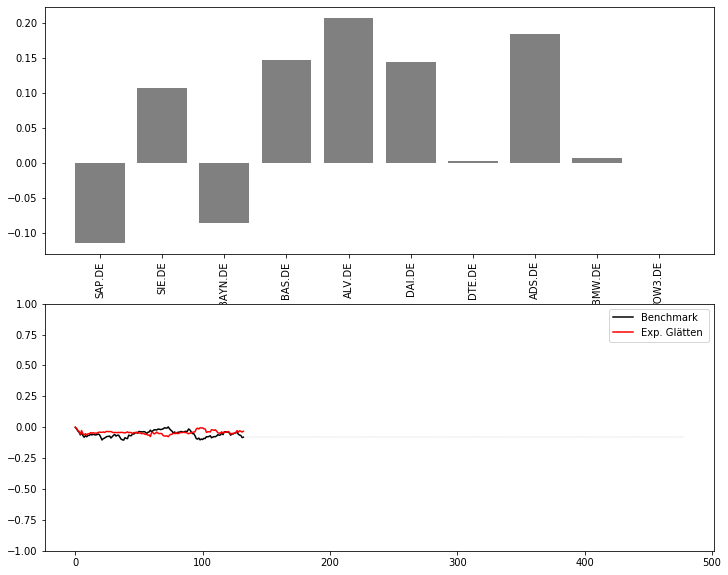

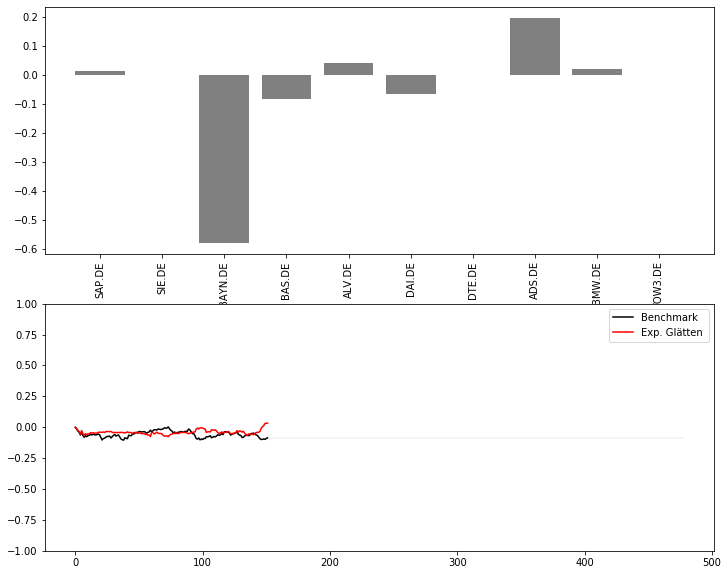

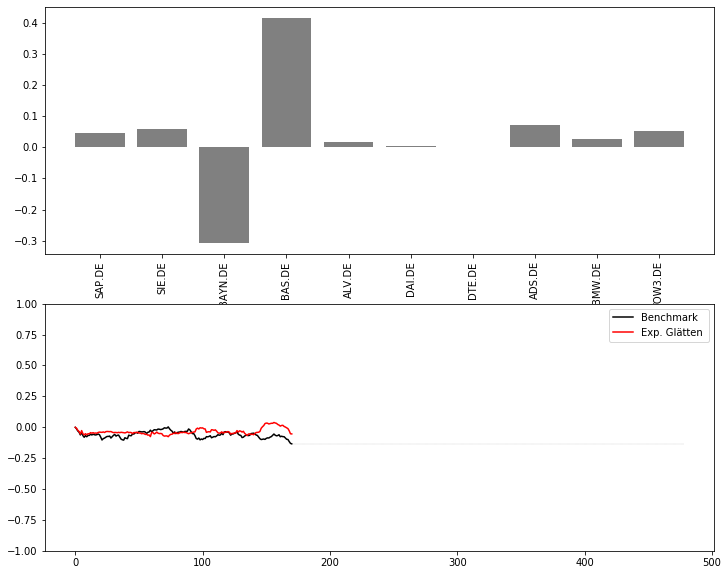

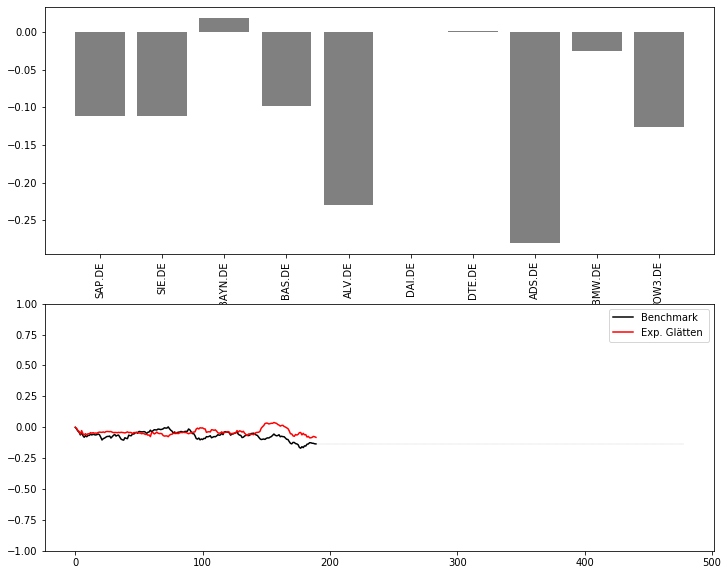

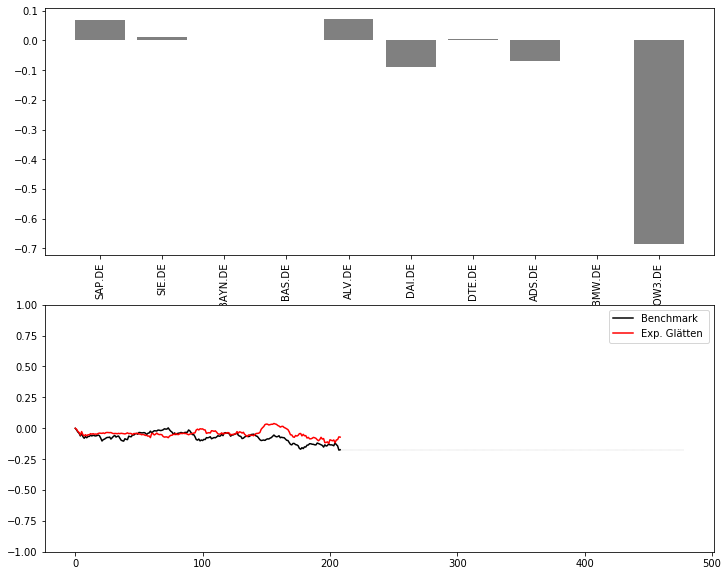

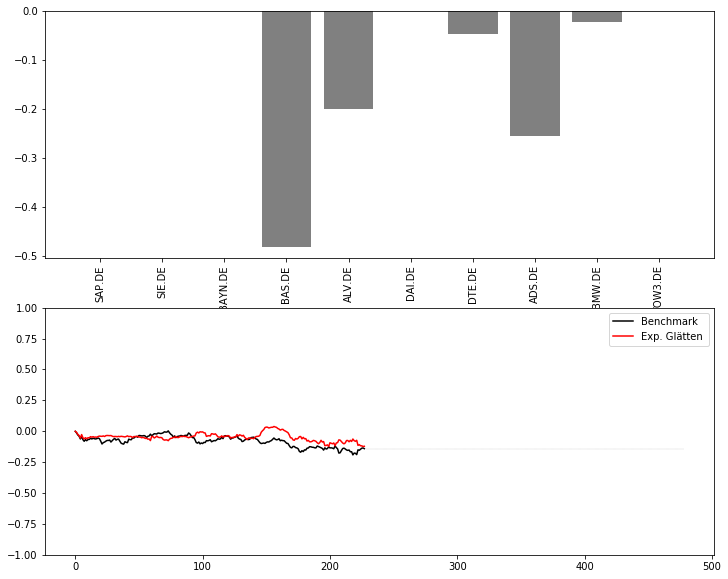

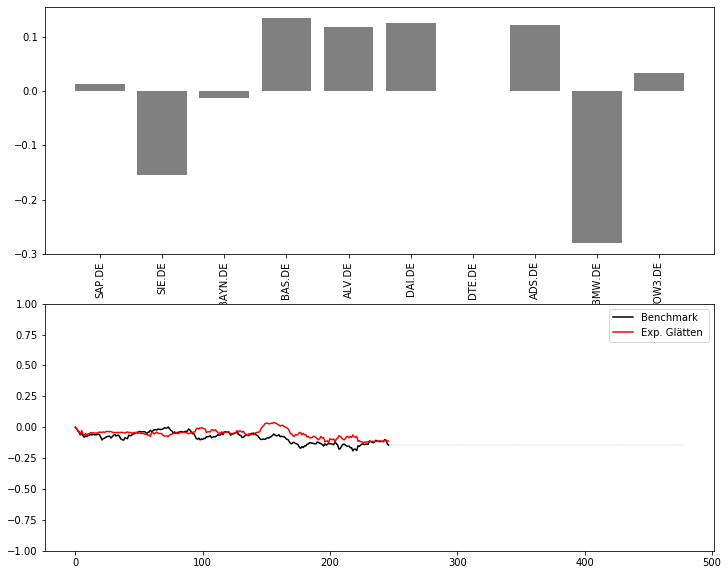

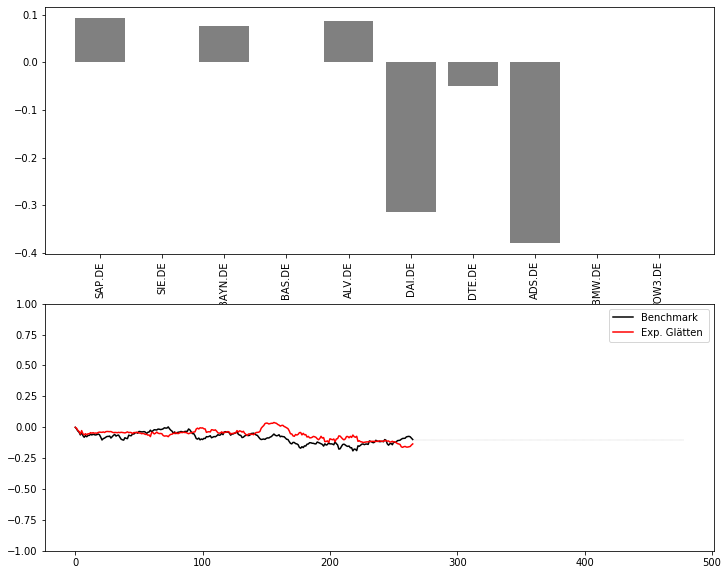

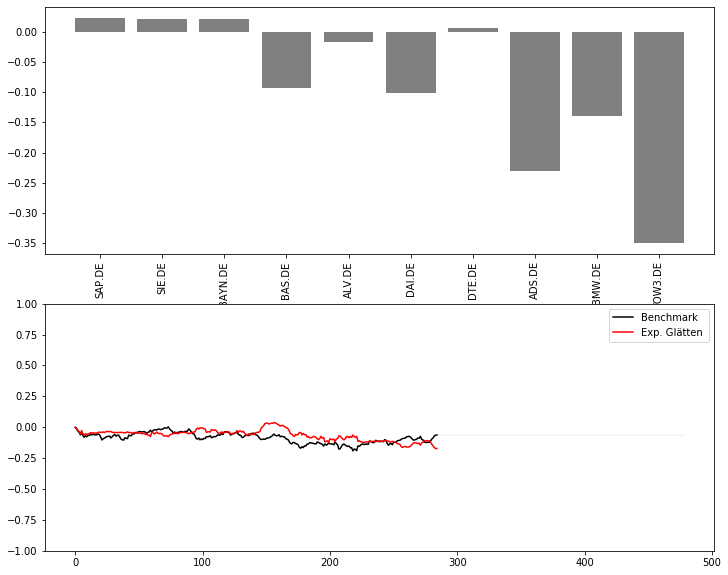

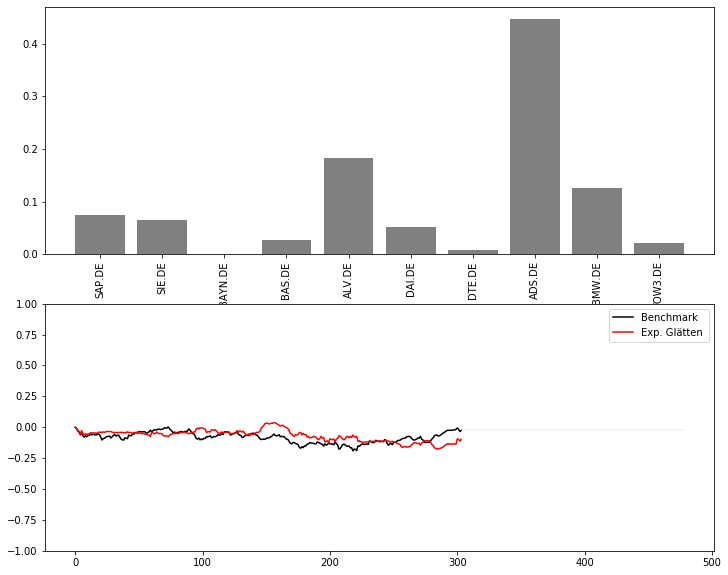

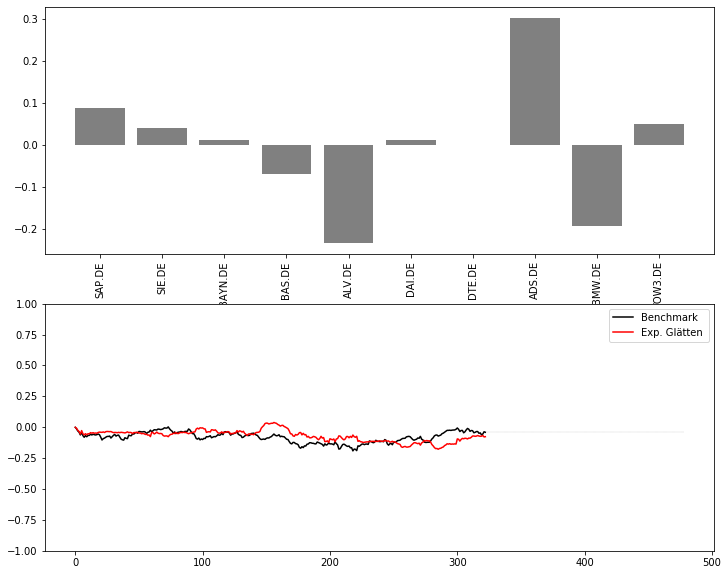

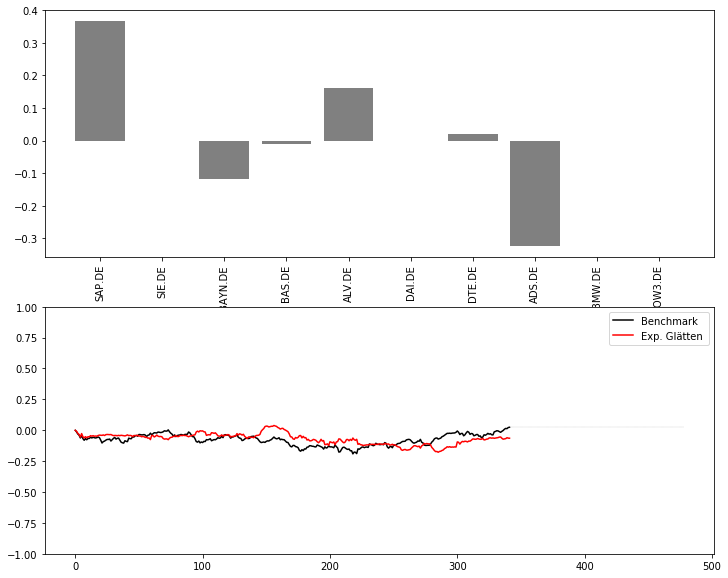

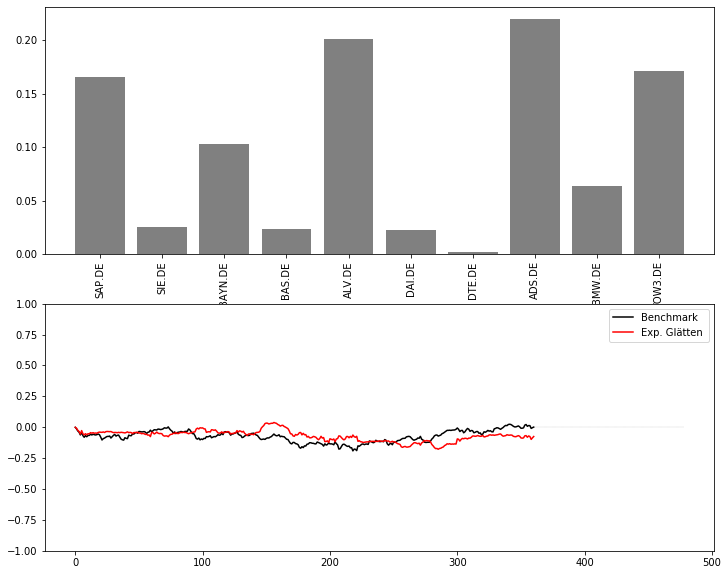

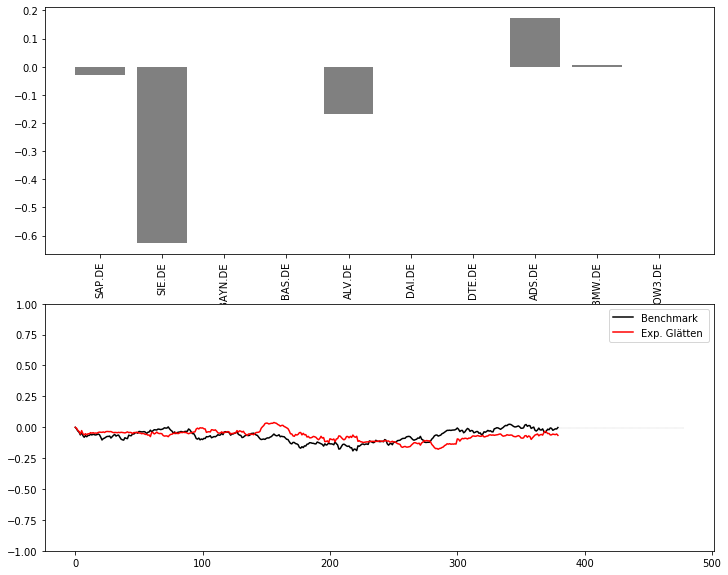

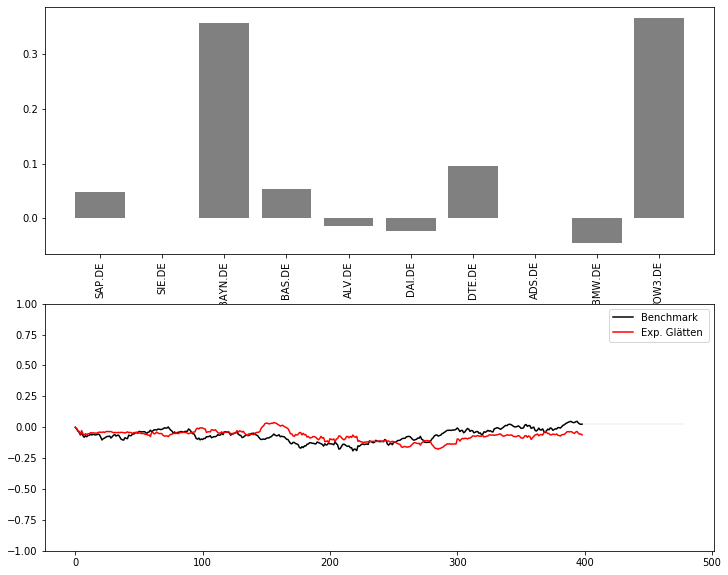

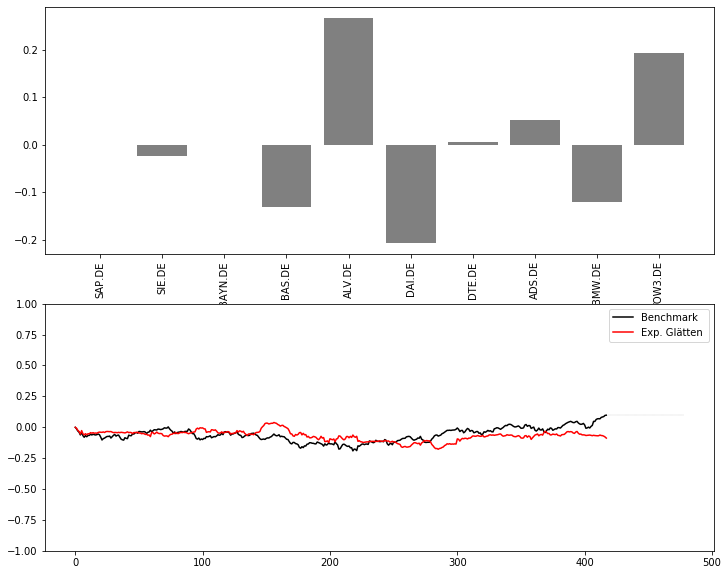

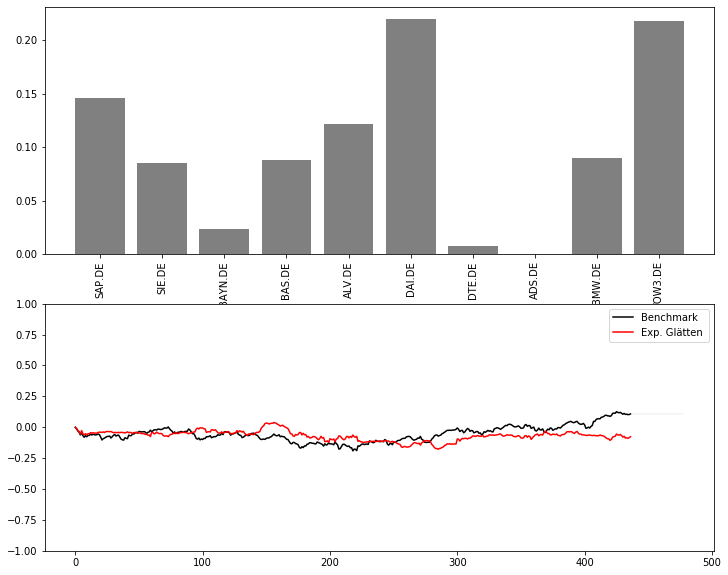

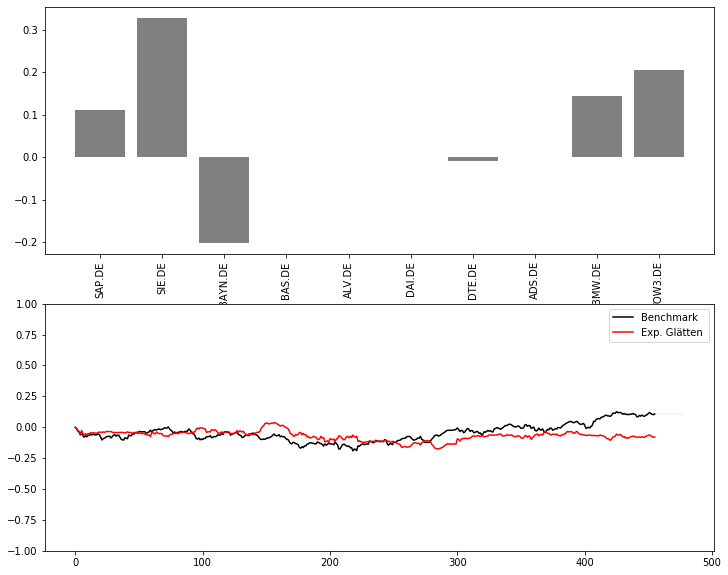

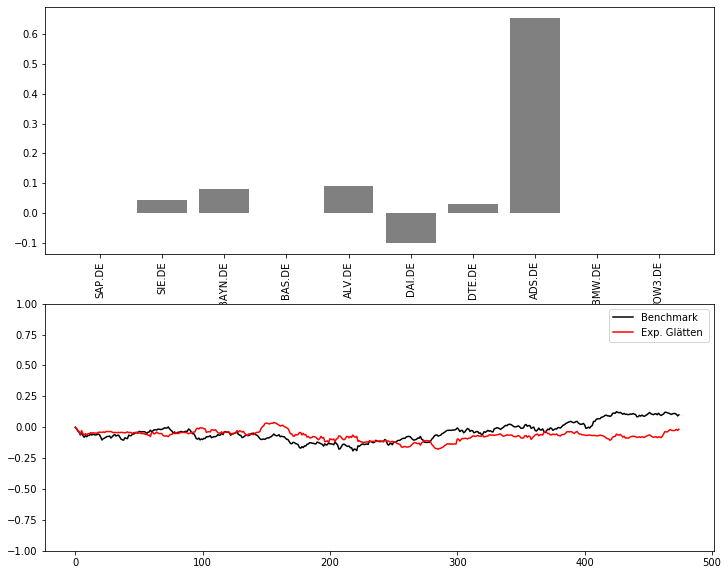

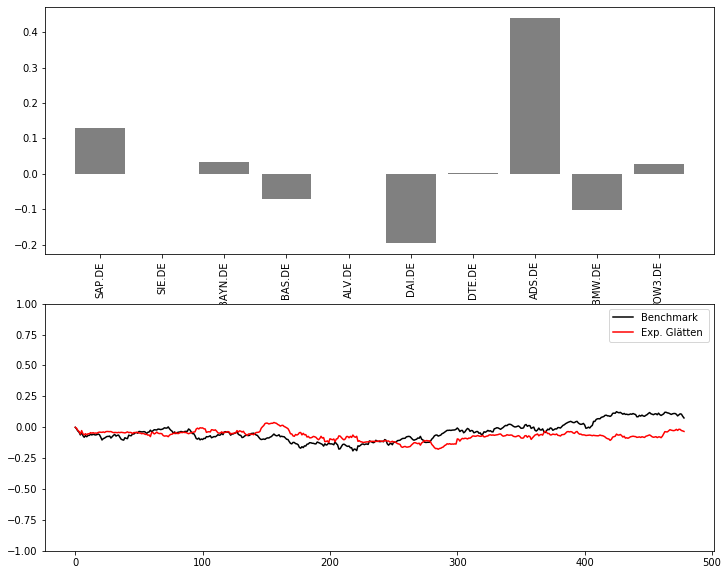

In [23]:
plot_results(result_equal, 
             result_smooth, 
             actions_smooth,
             N_ASSETS,
             state.columns, 
             'Exp. Glätten ', './images/smoothing/', 'series')

# Fazit:



### Überblick über die Kennzahlen der einzelnen Methoden


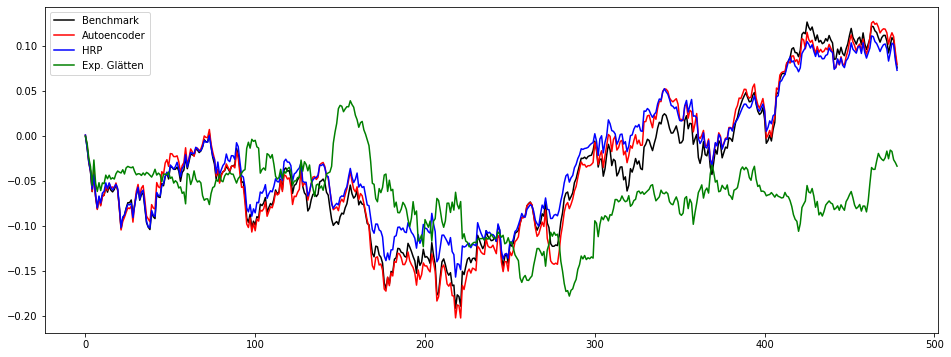

Portfolio Rendite Volatilität Sharpe-Ratio alpha beta
EQUAL [0.0002, 0.01, 0.2502, -0.0, 1.0]
AUTOENCODER [0.0002, 0.0104, 0.2491, 0.0, 1.0096]
HRP [0.0002, 0.0089, 0.2687, 0.0, 0.8495]
SMOOTHING [-0.0001, 0.0088, -0.1249, -0.0, -0.1337]


In [24]:
# Renditeverlauf des Gesamtportfolios 
plt.figure(figsize=(16,6))
plt.plot(np.array(result_equal_vis).cumsum(),color = 'black', label = 'Benchmark') 
plt.plot(np.array(result_ae_vis).cumsum(),color = 'red', label = 'Autoencoder')
plt.plot(np.array(result_hrp_vis).cumsum(),color = 'blue', label = 'HRP') 
plt.plot(np.array(result_smooth_vis).cumsum(),color = 'green', label = 'Exp. Glätten') 
plt.legend()
plt.show()


print('Portfolio' ,'Rendite','Volatilität','Sharpe-Ratio','alpha', 'beta' )
print('EQUAL', print_stats(result_equal_vis, result_equal_vis))
print('AUTOENCODER', print_stats(result_ae_vis, result_equal_vis))
print('HRP', print_stats(result_hrp_vis, result_equal_vis))
print('SMOOTHING', print_stats(result_smooth_vis, result_equal_vis))

#### Überblick 60 Tage Trainings-, sowie Haltedauer 
Portfolio Rendite Volatilität Sharpe-Ratio alpha beta
- EQUAL [0.0002, 0.01, 0.3514, -0.0, 1.0]
- AUTOENCODER [0.0003, 0.0104, 0.4775, 0.0001, 1.0113]
- HRP [0.0002, 0.0088, 0.4238, 0.0, 0.8501]
- SMOOTHING [-0.0005, 0.0099, -0.8464, -0.0005, 0.0391]

<div>
<img src="Überblick_Methoden_60Tage.png" width="1000"/>
</div>

- Autoencoder, HRP schneiden am besten ab, wobei HRP den Hauptanteil des Portfolios in die Telekom Aktie umschichtet
- Kennzahlen der Methoden ziemlich nah an der Benchmark bis auf exp. Glätten


#### Überblick 20 Tage Trainings-, sowie Haltedauer 

Portfolio Rendite Volatilität Sharpe-Ratio alpha beta
- EQUAL [0.0002, 0.01, 0.2502, -0.0, 1.0]
- AUTOENCODER [0.0003, 0.0103, 0.3942, 0.0001, 1.0015]
- HRP [0.0002, 0.0089, 0.2687, 0.0, 0.8495]
- SMOOTHING [-0.0001, 0.0088, -0.1249, -0.0, -0.1337]

<div>
<img src="Überblick_Methoden_20Tage.png" width="1000"/>
</div>

- Autoencoder schneidet am besten ab 



### Fazit:



- Betrachtung der Kennzahlen (Sharpe-Ratio) : Autoencoder und Riskoaufteilung mit hierarchischem Clustering schneiden am besten ab  
- Ausblick: Performance der Methoden mit weiteren Datensätzen bzw. Betrachtung der Daten über einen längeren Zeitraum 

- Kritisch zu bemerken: Die Gewichtung einzelner Aktien im Portfolio ist teilweise sehr hoch, dadurch entsteht ein konzentriertes Risiko

- Trainingszeitraum, Haltedauer und Prognosehorizont (exp. Glätten) besitzen einen Einfluss auf die Kennzahlen,
wobei je kürzer der Anlagezeitraum ist, umso mehr Rauschen ist in den Daten
- Autoencoder: Welche Dimensionsreduzierung ist sinnhaft, sodass der Prognosefehler minimal  und der Rechenaufwand überschaubar bleibt ? 
- Schlechte Performance des prognosebasiertes Portfolio : Zu simples Modell zur Prognose verwendet, die Vewendung eines stochastisches Volatilitätsmodell (bspw. Garch ) ist zu empfehlen

